# Technical Test: Analysis of Synthetic EHR Data from Synthea

This notebook addresses the four-part technical test outlined in the UCL Research Fellow position (B02 08645). The tasks include data cleaning, descriptive analysis, clinical subgroup analysis, and prevalence estimation of hypertension.

**Author:** [Sabrina Ansarey]  
**Date:** [17/5/25]  

---

## Table of Contents
- [Introduction](#introduction)
- [Methods](#methods)
- **Data Preparation**
  - [1. Data Loading & Cleaning](#1-data-loading-and-cleaning)
- **Descriptive Analysis**
  - [2. Patient Conditions & Observations](#2-descriptive-analysis-of-patients-conditions-and-observations)
- **Hypertension Subgroup**
  - [3. Blood Pressure & BMI Distributions](#3-blood-pressure-and-bmi-distributions-in-hypertensive-patients)
- **Prevalence Estimation**
  - [4. Hypertension Prevalence (Crude & UK-Adjusted)](#4-prevalence-of-hypertension-crude-and-adjusted-to-uk-population)
- [Discussion](#discussion)
- [Conclusion](#conclusion)
- [References](#reference)




## Introduction

The analysis aimed to demonstrate the ability to work with electronic health record (EHR) data generated by the Synthea simulation platform. The dataset was designed to replicate real-world challenges, including missing data, inconsistent coding, and demographic variability. The notebook presented a complete analytical pipeline encompassing data curation, patient profiling, subgroup clinical analysis, and the epidemiological estimation of hypertension prevalence.


## Method

All analyses were conducted within a Jupyter Notebook (version 6.5.2) executing Python 3.10.9 (Clang 14.0.6). Data manipulation and statistical computation were performed using the Pandas library, while visualisations were produced with Matplotlib.

Synthetic electronic health records generated by Synthea were imported from five CSV files—patients, conditions, observations, encounters and medications—each read into Pandas DataFrames with clinical code columns explicitly cast to string to preserve trailing ".0" notation. The condition, observation, encounter and medication tables were supplied in GZIP-compressed form and decompressed on load. Three supplementary lookup tables (SNOMED, LOINC and RxNorm) were employed to map raw codes to human-readable descriptions. Date fields in the patient's table ('BIRTHDATE' and 'DEATHDATE') were parsed with `pd.to_datetime(errors='coerce')`, thereby flagging any invalid or missing timestamps.

Quality-control filters were applied to exclude patients with implausible or incomplete demographic data. Specifically, individuals were removed if their recorded date of death preceded their date of birth, if the birth date was missing, if gender fell outside the recognised categories ('M' or 'F'), or if the computed age at last recorded event was negative. The age at the latest event was calculated by identifying each patient's most recent event across encounters, observations, conditions and medications, then computing the year interval between birth and the earlier death or lastest recorded event. All patients flagged by any criterion were omitted, and the remaining cohort was used to filter the clinical event tables.

Clinical codes were then validated and merged with their respective dictionaries. Observation records were restricted to those whose LOINC codes appeared in the LOINC lookup. Medication codes had any trailing ".0" removed before filtering against the RxNorm dictionary. Condition codes were standardised by stripping suffixes before merging with the SNOMED dictionary to append descriptive names. Records with missing or unmapped codes were discarded before further analysis.

Descriptive statistics summarised the post-QC cohort, reporting raw and clean patient counts and the total and unique patient counts in each clinical table. Demographic profiles, including gender proportions and recoded ethnicity categories, were tabulated. The ten most frequent SNOMED conditions, LOINC observations and RxNorm medications were identified and visualised using bar charts.

To characterise differences in cardiovascular risk factors between patients with and without a recorded hypertension diagnosis, we extracted each patient's most recent systolic blood pressure (SBP; LOINC 8480-6), diastolic blood pressure (DBP; LOINC 8462-4), and body‐mass index (BMI; LOINC 39156-5) after QC filtering. For subgroup analysis, Hypertensive status was defined by the presence of SNOMED code 59621000; all other patients constituted the non-hypertensive group. All systolic (LOINC 8480–6), diastolic (LOINC 8462–4) and body mass index (LOINC 39156–5) measurements were converted to numeric values; summary statistics (count, mean, standard deviation, minimum and maximum) were computed and depicted as histograms with mean annotations. In addition, each patient's most recent SBP (LOINC 8480-6), DBP (LOINC 8462-4) and BMI (LOINC 39156-5) were pulled and flagged by hypertension status (SNOMED 59621000 vs non-HTN). Continuous SBP, DBP and BMI distributions were compared between the two groups using side-by-side boxplots annotated with red diamonds for the mean ± 95 % confidence interval (mean ± 1.96·SE). Two-sample t-tests were used to test for statistically significant differences in mean SBP, DBP and BMI. To explore sex-specific patterns, all comparisons were then stratified by sex, and a "high-risk" hypertensive subgroup—defined by SBP ≥ 140 mmHg, DBP ≥ 90 mmHg and BMI ≥ 30 kg/m²—was characterised in terms of age and sex composition. Finally, the proportion of uncontrolled hypertension (SBP ≥ 140 or DBP ≥ 90) was computed separately in males and females to compare control rates across sexes.


Sex-stratified logistic regression models were fitted using Statsmodels' logit function, with BMI category (normal weight as the reference) and age as predictors to quantify the association between BMI category and hypertension. Odds ratios with 95% confidence intervals were reported for each BMI category.

Hypertension prevalence was estimated using three different methods. Crude prevalence was defined as the proportion of patients with recorded hypertension after data cleaning, and 95% confidence intervals were calculated. Age-specific prevalence was computed for five-year age bands, each with an associated 95% confidence interval. Direct age‐standardisation to the 2021 UK population employed predefined age-group weights to derive an age-adjusted prevalence estimate, with confidence bounds obtained via the delta method. Finally, sex-specific age-adjusted prevalence estimates were generated using the same approach for males and females.


The notebook is divided into four sections, each combining relevant methods and results:

1. **Data Loading and Cleaning** – Describes the quality control process, code validation, and derivation of patient age.
2. **Descriptive Analysis** – Summarises patient demographics, clinical conditions, observations, and medications.
3. **Hypertension Subgroup Analysis** – Explores blood pressure and BMI distributions among hypertensive patients, including sex-specific patterns and regression modelling.
4. **Prevalence Estimation** – Calculates crude and UK-standardised hypertension prevalence, including sex-specific rates.


## Results

### 1 Data Loading and Cleaning



The workflow begins by importing the necessary libraries (e.g., `pandas`) and loading the CSV files for patients, conditions, observations, encounters, and medications. Data types are explicitly defined for key columns (such as medical codes) to preserve them as strings. Compressed files are handled directly during import.

The initial step involves inspecting the datasets for structural issues such as missing values or logically inconsistent dates. Cleaning rules are applied systematically:

* **Quality control (QC) filtering:** Patients with missing essential data (e.g., birth dates), logically invalid records (e.g., death dates earlier than birth dates), or incorrect values (e.g., non-binary gender entries) are excluded. All records associated with these patients across other tables have also been removed to maintain consistency.

* **Standardisation of medical coding:** Numeric codes containing formatting artifacts (e.g., trailing `.0`) are corrected. Records containing codes not in the official reference dictionaries (SNOMED, LOINC, RxNorm) are removed. Any rows with missing codes are excluded, as they cannot be reliably interpreted.

* **Referential integrity and enrichment:** All remaining records are filtered to include only those associated with valid patients. Medical codes are prepared for merging with external dictionaries to attach human-readable descriptions to conditions, observations, and medications.

This preprocessing ensures that the dataset is internally consistent, clinically interpretable, and ready for downstream analysis.


In [1]:
#import sys
#print(sys.version)

#import notebook
#print(notebook.__version__)


In [2]:
import pandas as pd
import gzip
import os
import matplotlib.pyplot as plt
import numpy as np


# Define relative path to the data folder
data_path = "./"  # or use "./data/dest/" if inside a subfolder

In [3]:
# Load datasets (using dtype=str for code columns to keep codes intact)
patients = pd.read_csv('patients.csv', dtype={'Id': str})
conditions = pd.read_csv('conditions.csv.gz', compression='gzip', dtype={'CODE': str})
observations = pd.read_csv('observations.csv.gz', compression='gzip', dtype={'CODE': str})
encounters = pd.read_csv('encounters.csv.gz', compression='gzip')
medications = pd.read_csv('medications.csv.gz', compression='gzip', dtype={'CODE': str, 'REASONCODE': str})

# Load dictionaries for code lookups
dict_snomed = pd.read_csv('dictionary_snomed.csv', dtype={'CODE': str})
dict_loinc = pd.read_csv('dictionary_loinc.csv', dtype={'CODE': str})
dict_rxnorm = pd.read_csv('dictionary_rxnorm.csv', dtype={'CODE': str})


### Patient Demographics Quality Control and Age-at-Event Derivation

Quality control checks were performed on the `patients.csv` dataset to ensure data integrity. The objective was to remove incomplete or logically inconsistent records before downstream analysis.

The following exclusions were applied:

* Patients with missing or implausible birthdates (e.g. dates in the future)
* Patients with death dates recorded earlier than their birthdates
* Patients with missing or invalid gender values (i.e. not 'M' or 'F')

In addition to these demographic checks, a derived variable `AGE_AT_LAST_EVENT` was calculated to estimate each patient's age at the time of their most recent clinical activity. This was based on:

* The latest recorded date across all clinical datasets (`encounters`, `conditions`, `medications`, and `observations`)
* The year of birth as the baseline
* The date of death, where applicable, taking precedence over other event dates

Patients with negative calculated ages were also excluded, indicating inconsistencies between event dates and birthdates.

These steps resulted in a clean and demographically valid patient cohort suitable for linkage with clinical datasets and use in age-related analyses such as regression modelling and standardised prevalence estimation.


In [4]:
# Convert date columns to datetime for logical checks
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'], errors='coerce')
patients['DEATHDATE'] = pd.to_datetime(patients['DEATHDATE'], errors='coerce')

# Identify QC issues in patients
qc_fail_ids = set()

#  Death before birth
mask_death_before_birth = (
    patients['DEATHDATE'].notna() &
    patients['BIRTHDATE'].notna() &
    (patients['DEATHDATE'] < patients['BIRTHDATE'])
)
qc_fail_ids.update(patients[mask_death_before_birth]['Id'])

#  Missing birth date or invalid birth year
mask_missing_birth = patients['BIRTHDATE'].isna()
qc_fail_ids.update(patients[mask_missing_birth]['Id'])

# Missing or invalid gender
mask_invalid_gender = ~patients['GENDER'].isin(['M', 'F'])
qc_fail_ids.update(patients[mask_invalid_gender]['Id'])



#  Compute AGE_AT_LAST_EVENT
# Helper: drop timezone info
def drop_tz(series):
    s = pd.to_datetime(series, errors='coerce')
    if hasattr(s.dt, 'tz'):
        try:
            return s.dt.tz_convert(None)
        except Exception:
            return s
    return s

# Get each patient's last activity date
enc_latest  = drop_tz(encounters  .groupby('PATIENT')['START'].max())
obs_latest  = drop_tz(observations.groupby('PATIENT')['DATE' ].max())
cond_latest = drop_tz(conditions  .groupby('PATIENT')['START'].max())
med_latest  = drop_tz(medications.groupby('PATIENT')['START'].max())

# Combine to get latest_event per patient
latest_events = pd.concat([
    enc_latest.rename('enc_latest'),
    obs_latest.rename('obs_latest'),
    cond_latest.rename('cond_latest'),
    med_latest.rename('med_latest')
], axis=1)
latest_events['latest_event'] = latest_events.max(axis=1)

# Merge latest event with patients
patients = patients.merge(
    latest_events[['latest_event']],
    how='left',
    left_on='Id',
    right_index=True
)

# Compute age
def compute_age(row):
    if pd.notna(row['DEATHDATE']):
        return row['DEATHDATE'].year - row['BIRTHDATE'].year
    if pd.notna(row['latest_event']):
        return row['latest_event'].year - row['BIRTHDATE'].year
    return pd.NA

patients['AGE_AT_LAST_EVENT'] = patients.apply(compute_age, axis=1)

# Drop negative ages
mask_negative_age = patients['AGE_AT_LAST_EVENT'] < 0
qc_fail_ids.update(patients[mask_negative_age]['Id'].tolist())

# Count of failing patients
print(f"Patients failing QC: {len(qc_fail_ids)}")




Patients failing QC: 44


In [5]:
# Exclude failing patients from analysis
clean_patients = patients[~patients['Id'].isin(qc_fail_ids)].copy()
clean_patient_ids = set(clean_patients['Id'])

# Filter other tables by remaining valid patient IDs
clean_conditions   = conditions[conditions['PATIENT'].isin(clean_patient_ids)].copy()
clean_observations = observations[observations['PATIENT'].isin(clean_patient_ids)].copy()
clean_encounters   = encounters[encounters['PATIENT'].isin(clean_patient_ids)].copy()
clean_medications  = medications[medications['PATIENT'].isin(clean_patient_ids)].copy()

# Summary of patient counts before/after filtering
raw_patient_count   = patients['Id'].nunique()
clean_patient_count = clean_patients['Id'].nunique()
excluded_count      = raw_patient_count - clean_patient_count
print(f"Raw patient count (before QC filtering): {raw_patient_count}")
print(f"Clean patient count (after QC filtering): {clean_patient_count}")
print(f"Number of patients excluded during QC: {excluded_count}")


Raw patient count (before QC filtering): 1162
Clean patient count (after QC filtering): 1118
Number of patients excluded during QC: 44


In [6]:
# Function to strip trailing .0 from code fields
def strip_float_str(code):
    if isinstance(code, str) and code.endswith('.0'):
        return code[:-2]
    return code


### Clean Conditions (SNOMED codes)

This section loaded and cleaned the `conditions.csv` file. Invalid or unrecognised SNOMED codes were removed to ensure all records represented interpretable clinical conditions. This step was essential for maintaining consistency in downstream clinical analyses.

In [7]:
clean_conditions['CODE'] = clean_conditions['CODE'].apply(strip_float_str)
valid_snomed = set(dict_snomed['CODE'])
clean_conditions = clean_conditions[clean_conditions['CODE'].isin(valid_snomed)]


### Clean Observations (LOINC codes)

This section processed the `observations.csv` file. Each row represented a clinical measurement (e.g. blood pressure, BMI) coded using the LOINC ontology. To ensure consistency:

* Observations with missing or null codes were excluded
* Only codes present in the official LOINC dictionary were retained

This filtering ensured that each remaining observation corresponded to a valid, interpretable clinical test. The cleaned observation data were essential for subsequent blood pressure and BMI distribution analyses.


In [8]:
clean_observations = clean_observations[clean_observations['CODE'].notna()]
valid_loinc = set(dict_loinc['CODE'])
clean_observations = clean_observations[clean_observations['CODE'].isin(valid_loinc)]


### Clean Medications (RxNorm codes)

This section loaded and cleaned the `medications.csv` file, which contained drug prescriptions encoded using the RxNorm vocabulary. To prepare the dataset:

* Medication codes with invalid formatting (e.g. strings with trailing decimals such as `"123456.0"`) were corrected
* Rows with missing medication codes were removed
* Only medications with valid RxNorm identifiers from the reference dictionary were retained

This step ensured that the final medication table included only clinically recognised treatments, reducing the risk of introducing noise into prescription data analyses.


In [9]:
clean_medications['CODE'] = clean_medications['CODE'].apply(strip_float_str)
valid_rxnorm = set(dict_rxnorm['CODE'])
clean_medications = clean_medications[clean_medications['CODE'].isin(valid_rxnorm)]
clean_medications = clean_medications[clean_medications['CODE'].notna()]


### Attach Descriptions for Clinical Terms

In [10]:
# Standardise CODE columns in both datasets before merging
clean_conditions['CODE'] = clean_conditions['CODE'].astype(str).str.strip().str.replace(r'\.0$', '', regex=True)
dict_snomed['CODE'] = dict_snomed['CODE'].astype(str).str.strip().str.replace(r'\.0$', '', regex=True)

# Perform the merge
clean_conditions = clean_conditions.merge(dict_snomed, how='left', on='CODE')
clean_conditions.rename(columns={'DESCRIPTION': 'CONDITION_NAME'}, inplace=True)


# Link LOINC descriptions for observations
clean_observations = clean_observations.merge(dict_loinc, how='left', left_on='CODE', right_on='CODE')
clean_observations.rename(columns={'DESCRIPTION': 'OBS_NAME'}, inplace=True)

# Link RxNorm descriptions for medications
clean_medications = clean_medications.merge(dict_rxnorm, how='left', left_on='CODE', right_on='CODE')
clean_medications.rename(columns={'DESCRIPTION': 'MED_NAME'}, inplace=True)


### Final Dataset Shapes
The data has been loaded and cleaned. We have 1130 patients remaining after QC (out of 1162 original), and the related tables have been filtered and cleaned accordingly. The data is now ready for analysis

In [11]:
# Final shapes of the cleaned datasets
print("Cleaned DataFrame Shapes:")
print(f"- Patients:     {clean_patients.shape[0]:,} rows × {clean_patients.shape[1]} columns")
print(f"- Conditions:   {clean_conditions.shape[0]:,} rows × {clean_conditions.shape[1]} columns")
print(f"- Observations: {clean_observations.shape[0]:,} rows × {clean_observations.shape[1]} columns")
print(f"- Medications:  {clean_medications.shape[0]:,} rows × {clean_medications.shape[1]} columns\n")


Cleaned DataFrame Shapes:
- Patients:     1,118 rows × 27 columns
- Conditions:   36,805 rows × 6 columns
- Observations: 524,626 rows × 9 columns
- Medications:  56,129 rows × 12 columns



## 2 Descriptive Analysis of Patients Conditions and Observations

This section provided a high-level overview of the patient population and their recorded clinical data. It included counts of unique patients, the most frequently coded clinical entries (SNOMED, LOINC, RxNorm), age distributions, and demographic breakdowns.




After rigorous quality control and date sanitisation, the final cohort consisted of **1,118** synthetic patients. Women (n = 586, 52.4%) and men (n = 532, 47.6%) were nearly equally represented. Ages ranged from **0** to **121** years (mean = 42.3, median = 42, SD = 25.6), with 156 individuals (14.0%) recorded as deceased and 962 alive at the last follow-up. Ethnicity was predominantly White (n = 918, 82.1%), followed by Black (8.4%), Asian (7.8%), Other (1.5%), and Native (0.2%).

**Condition records** comprised **36,927** entries across **1,112** patients (99.5% of the cohort), encompassing 201 unique SNOMED codes. Over half of all condition entries were concentrated in the five most frequent codes, which primarily reflected social determinants:

* **Full-time employment (160903007):** 13,468 records (36.5%)
* **Stress (73595000):** 4,976 (13.5%)
* **Part-time employment (160904001):** 2,387 (6.5%)
* **Social isolation (422650009):** 1,207 (3.3%)
* **Viral sinusitis (444814009):** 1,191 (3.2%)

Medical diagnoses included **Hypertension (59621000)** in 284 patients (25.4% of the cohort) and **COVID-19 (840539006)** in 89 patients (8.0%).

**Observation records** totalled **527,072** entries (231 unique LOINC codes) across **1,128** patient visits. Vital signs dominated the most common entries:

* **Pain severity (72514-3):** 14,111 (2.7%)
* **Systolic blood pressure (8480-6):** 14,039 (2.7%)
* **Diastolic blood pressure (8462-4):** 14,039 (2.7%)
* **Body weight (29463-7):** 12,845 (2.4%)
* **Heart rate (8867-4):** 12,598 (2.4%)

The near-equal frequency of systolic and diastolic blood pressure measurements indicated that these vital signs were typically recorded in pairs. Pain severity scoring appeared to be captured systematically at nearly every encounter.

**Medication records** included **56,438** entries (172 unique RxNorm codes), spanning **1,085** patients. The five most frequently prescribed drugs reflected typical management strategies for chronic conditions:

* **Lisinopril 10 mg** (314076): 8,085 orders (14.3%)
* **Hydrochlorothiazide 25 mg** (310798): 7,165 (12.7%)
* **Amlodipine 2.5 mg** (308136): 5,865 (10.4%)
* **Insulin human 70/30** (106892): 3,861 (6.8%)
* **Metformin 500 mg XR** (860975): 2,991 (5.3%)

The prominence of ACE inhibitors and diuretics corresponded with the high prevalence of hypertension, while frequent use of insulin and metformin highlighted the burden of concurrent diabetes.

This synthetic cohort demonstrated routine vital sign monitoring, a strong representation of social-determinant conditions, and medication patterns consistent with chronic disease management. These features validated the realism of the Synthea data and provided a robust foundation for epidemiological training and methodological development.


In [12]:
# Basic descriptive stats after cleaning
num_patients = clean_patients.shape[0]
num_conditions = clean_conditions.shape[0]
num_observations = clean_observations.shape[0]
num_medications = clean_medications.shape[0]
unique_patients_in_conditions   = clean_conditions['PATIENT'].nunique()
unique_patients_in_observations = clean_observations['PATIENT'].nunique()
unique_patients_in_medications  = clean_medications['PATIENT'].nunique()

print(f"Patients:     {num_patients:,}")
print(f"Conditions:   {num_conditions:,}")
print(f"Observations: {num_observations:,}")
print(f"Medications:  {num_medications:,}\n")

print(f"Patients with condition records:   {unique_patients_in_conditions:,}")
print(f"Patients with observation records: {unique_patients_in_observations:,}")
print(f"Patients with medication records:  {unique_patients_in_medications:,}\n")

# Gender breakdown
gender_counts = clean_patients['GENDER'].value_counts()
for gender, count in gender_counts.items():
    pct = count / num_patients * 100
    label = 'Female' if gender == 'F' else 'Male' if gender == 'M' else gender
    print(f"{label:>6}: {count:,} ({pct:.1f}%)")


Patients:     1,118
Conditions:   36,805
Observations: 524,626
Medications:  56,129

Patients with condition records:   1,102
Patients with observation records: 1,118
Patients with medication records:  1,075

Female: 586 (52.4%)
  Male: 532 (47.6%)


In [13]:
# Recode inconsistent ethnicity values in clean_patients
recode_map = {
    'XJniDSe': 'asian',   # Map XJniDSe to asian
    '???-':    'other'    # Map unknown placeholder to other
}

# Apply the recoding
clean_patients['RACE'] = clean_patients['RACE'].replace(recode_map)

# (Optional) Standardise capitalization
clean_patients['RACE'] = clean_patients['RACE'].str.title()

# Verify the new unique ethnicity categories
print("unique ethnicities:")
print(clean_patients['RACE'].unique())


unique ethnicities:
['White' 'Black' 'Asian' 'Other' 'Native']


In [14]:

# Total patients
total_patients = clean_patients.shape[0]

# Death count
death_count = clean_patients['DEATHDATE'].notna().sum()
alive_count = total_patients - death_count
death_percent = round(death_count / total_patients * 100, 1)

print(f"\nPatients with a recorded death date: {death_count} ({death_percent}%)")
print(f"Patients alive: {alive_count}")

# Race/Ethnicity breakdown with percentages
race_counts = clean_patients['RACE'].value_counts()
race_percentage = (race_counts / total_patients * 100).round(1)

race_summary = pd.DataFrame({
    'count': race_counts,
    'percentage': race_percentage
})

print("\nRace/Ethnicity distribution:")
print(race_summary)




Patients with a recorded death date: 156 (14.0%)
Patients alive: 962

Race/Ethnicity distribution:
        count  percentage
White     918        82.1
Black      94         8.4
Asian      87         7.8
Other      17         1.5
Native      2         0.2


In [15]:
#  Compute top 5 City–State combinations by patient count
top5_locations = (
    clean_patients
    .groupby(['CITY', 'STATE'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
    .head(5)
)

#  Calculate percentage of the total cohort
total_patients = clean_patients.shape[0]
top5_locations['percentage'] = (top5_locations['count'] / total_patients * 100).round(1)

#  Display as a neat table
print("Top 5 City–State areas by patient count:\n")
print(top5_locations.to_string(index=False))


Top 5 City–State areas by patient count:

       CITY         STATE  count  percentage
     Boston Massachusetts    112        10.0
Springfield Massachusetts     29         2.6
 Somerville Massachusetts     22         2.0
  Worcester Massachusetts     22         2.0
     Quincy Massachusetts     22         2.0


In [16]:
# Print the dimensions of clean_patients in a clear format
rows, cols = clean_patients.shape
print(f"clean_patients has {rows:,} rows and {cols} columns")


clean_patients has 1,118 rows and 27 columns


In [17]:
# List all unique names
unique_conditions  = clean_conditions['CONDITION_NAME'].unique()
unique_observations = clean_observations['OBS_NAME'].unique()
unique_medications  = clean_medications['MED_NAME'].unique()



In [18]:
import re

# full list of renaming entries as a string
full_text = """
 - Risk activity involvement (finding) to Risk activity involvement
 - Body mass index 30+ - obesity (finding) to BMI 30+
 - Received certificate of high school equivalency (finding) to high school graduate
 - Acute viral pharyngitis (disorder) to Acute viral pharyngitis
 - Part-time employment (finding) to Part-time employment
 - Stress (finding) to Stress
 - Not in labor force (finding) to Economically inactive 
 - Viral sinusitis (disorder) to Viral sinusitis
 - Limited social contact (finding) to Limited social contact
 - Refugee (person) to Refugee
 - Social isolation (finding) to Social isolation
 - Received higher education (finding) to Higher education holder
 - Reports of violence in the environment (finding) to Exposure to environmental violence
 - Dyspnea (finding) to Dyspnea
 - Wheezing (finding) to Wheezing
 - Acute bronchitis (disorder) to Acute bronchitis
 - Victim of intimate partner abuse (finding) to Survivor of partner abuse
 - History of single seizure (situation) to Single seizure history
 - Served in armed forces (finding) to Military service
 - Chronic low back pain (finding) to Chronic low back pain
 - Chronic neck pain (finding) to Chronic neck pain
 - Unemployed (finding) to Unemployed
 - Severe anxiety (panic) (finding) to Severe anxiety
 - Transport problems (finding) to Transport problems
 - Lack of access to transportation (finding) to Lack of access to transportation
 - Anemia (disorder) to Anemia
 - Has a criminal record (finding) to Has a criminal record
 - Streptococcal sore throat (disorder) to Streptococcal sore throat
 - Misuses drugs (finding) to Misuses drugs
 - Cough (finding) to Cough
 - Fever (finding) to Fever
 - Fatigue (finding) to Fatigue
 - Loss of taste (finding) to Loss of taste
 - Respiratory distress (finding) to Respiratory distress
 - Acute deep venous thrombosis (disorder) to Acute deep venous thrombosis
 - Sepsis (disorder) to Sepsis
 - Metabolic syndrome X (disorder) to Metabolic syndrome X
 - Osteoporosis (disorder) to Osteoporosis
 - Malignant neoplasm of breast (disorder) to Malignant neoplasm of breast
 - Chronic kidney disease stage 1 (disorder) to Chronic kidney disease stage 1
 - Diabetic renal disease (disorder) to Diabetic renal disease
 - Chill (finding) to Chill
 - Acute bacterial sinusitis (disorder) to Acute bacterial sinusitis
 - History of cardiac arrest (situation) to History of cardiac arrest
 - Suspected lung cancer (situation) to Suspected lung cancer
 - Non-small cell lung cancer (disorder) to Non-small cell lung cancer
 - Non-small cell carcinoma of lung  TNM stage 1 (disorder) to Non-small cell carcinoma of lung  TNM stage 1
 - Chronic congestive heart failure (disorder) to Chronic congestive heart failure
 - Transformed migraine (disorder) to Transformed migraine
 - Fibromyalgia (disorder) to Fibromyalgia
 - Homeless (finding) to Homeless
 - Sore throat symptom (finding) to Sore throat symptom
 - Body mass index 40+ - severely obese (finding) to BMI 40+
 - Sputum finding (finding) to Sputum finding
 - Hemoptysis (finding) to Hemoptysis
 - Sepsis caused by virus (disorder) to Sepsis caused by virus
 - Diarrhea symptom (finding) to Diarrhea symptom
 - Chronic obstructive bronchitis (disorder) to Chronic obstructive bronchitis
 - Carcinoma in situ of prostate (disorder) to Carcinoma in situ of prostate
 - Headache (finding) to Headache
 - Muscle pain (finding) to Muscle pain
 - Joint pain (finding) to Joint pain
 - Acute respiratory failure (disorder) to Acute respiratory failure (
 - Pulmonary emphysema (disorder) to Pulmonary emphysema
 - History of myocardial infarction (situation) to History of myocardial infarction
 - Acute pulmonary embolism (disorder) to Acute pulmonary embolism
 - Injury of kidney (disorder) to Injury of kidney
 - Acute respiratory distress syndrome (disorder) to Acute respiratory distress syndrome
 - Cerebral palsy (disorder) to Cerebral palsy (
 - Spasticity (finding) to Spasticity
 - Intellectual disability (disorder) to Intellectual disability
 - Gastroesophageal reflux disease (disorder) to Gastroesophageal reflux disease
 - Nausea (finding) to Nausea
 - Vomiting symptom (finding) to Vomiting symptom
 - Alzheimer's disease (disorder) to Alzheimer's disease
 - Opioid abuse (disorder) to Opioid abuse
 - Chronic kidney disease stage 2 (disorder) to Chronic kidney disease stage 2
 - Microalbuminuria due to type 2 diabetes mellitus (disorder) to Microalbuminuria due to type 2 diabetes mellitus
 - At risk for suicide (finding) to sucidal ideation
 - Shock (disorder) to shock 
 - Pain (finding) to pain
 - Poor muscle tone (finding) to Poor muscle tone
 - Dislocation of hip joint (disorder) to Dislocation of hip joint
 - Familial Alzheimer's disease of early onset (disorder) to Familial Alzheimer's disease of early onset
 - Septic shock (disorder) to Septic shock
 - Spina bifida occulta (disorder) to Spina bifida occulta
 - Nasal congestion (finding) to Nasal congestion
 - Infection caused by Pseudomonas aeruginosa to Pseudomonas aeruginosa infection
 - Macular edema and retinopathy due to type 2 diabetes mellitus (disorder) to Macular edema and retinopathy due to type 2 diabetes mellitus
 - Proliferative diabetic retinopathy due to type II diabetes mellitus (disorder) to Proliferative diabetic retinopathy due to type II diabetes mellitus
 - Non-small cell carcinoma of lung  TNM stage 2 (disorder) to Non-small cell carcinoma of lung  TNM stage 2
 - History of lower limb amputation (situation) to History of lower limb amputation
 - Acquired coagulation disorder (disorder) to Acquired coagulation disorder
 - Injury of heart (disorder) to Injury of heart
"""

# Function to parse the text into a dictionary
def extract_renames(text):
    lines = text.strip().split("\n")
    replacements = {}
    for line in lines:
        line = line.strip().lstrip("-").strip()
        if " to " in line and not line.startswith("to "):
            old, new = re.split(r"\s+to\s+", line, maxsplit=1)
            replacements[old.strip()] = new.strip()
    return replacements

# Extract mapping and convert to DataFrame
renames = extract_renames(full_text)
renames_df = pd.DataFrame(list(renames.items()), columns=["Original Name", "Updated Name"])

# Show first few rows
print(renames_df.head())

# To save to Excel if needed
# renames_df.to_excel("renaming_dictionary.xlsx", index=False)


                                       Original Name  \
0                Risk activity involvement (finding)   
1            Body mass index 30+ - obesity (finding)   
2  Received certificate of high school equivalenc...   
3                 Acute viral pharyngitis (disorder)   
4                     Part-time employment (finding)   

                Updated Name  
0  Risk activity involvement  
1                    BMI 30+  
2       high school graduate  
3    Acute viral pharyngitis  
4       Part-time employment  


In [19]:
print(clean_conditions[['CODE', 'CONDITION_NAME']].dropna().head(10))
print("Unique CONDITION_NAME values:", clean_conditions['CONDITION_NAME'].nunique())


            CODE                                     CONDITION_NAME
0      160968000                Risk activity involvement (finding)
1       44465007                                    Sprain of ankle
2      162864005            Body mass index 30+ - obesity (finding)
3       59621000                                       Hypertension
4      105531004                   Housing unsatisfactory (finding)
5  5251000175109  Received certificate of high school equivalenc...
6      160903007                     Full-time employment (finding)
7      195662009                 Acute viral pharyngitis (disorder)
8      160904001                     Part-time employment (finding)
9       73595000                                   Stress (finding)
Unique CONDITION_NAME values: 203


In [20]:
import textwrap

def print_table(rows, headers, widths):
    # rows: list of tuples (code, name, count)
    # headers: tuple of header names
    # widths: tuple of column widths
    col1_w, col2_w, col3_w = widths
    print(f"{headers[0]:<{col1_w}} {headers[1]:<{col2_w}} {headers[2]:>{col3_w}}")
    for code, name, cnt in rows:
        wrapped = textwrap.wrap(name, col2_w)
        for i, line in enumerate(wrapped):
            if i == 0:
                print(f"{code:<{col1_w}} {line:<{col2_w}} {cnt:>{col3_w}}")
            else:
                print(f"{'':<{col1_w}} {line:<{col2_w}} {'':>{col3_w}}")
    print()

# Condition summary
total_conditions = clean_conditions.shape[0]
unique_condition_codes = clean_conditions['CODE'].nunique()
unique_condition_patients = clean_conditions['PATIENT'].nunique()

print("\nCondition Records Summary:")
print(f"- Total condition records:           {total_conditions:,}")
print(f"- Unique SNOMED codes used:          {unique_condition_codes:,}")
print(f"- Patients with ≥1 condition record: {unique_condition_patients:,}\n")

# Top 10 conditions
top_conditions = (
    clean_conditions.groupby(['CODE', 'CONDITION_NAME'])
    .size().reset_index(name='count')
    .sort_values('count', ascending=False).head(10)
)
print("Top 10 most frequent SNOMED conditions:")
print_table(
    list(zip(top_conditions['CODE'], top_conditions['CONDITION_NAME'], top_conditions['count'])),
    headers=('CODE', 'CONDITION_NAME', 'count'),
    widths=(10, 50, 5)
)

# Specific codes
for code, label in [('59621000', 'Hypertension'), ('840539006', 'COVID-19')]:
    subset = clean_conditions[clean_conditions['CODE'] == code]
    print(f"{label:<12} (code {code}): {subset.shape[0]:,} records for {subset['PATIENT'].nunique():,} patients")
print()

# Top 10 observations
top_observations = (
    clean_observations.groupby(['CODE', 'OBS_NAME'])
    .size().reset_index(name='count')
    .sort_values('count', ascending=False).head(10)
)
print("Top 10 most frequent LOINC observations:")
print_table(
    list(zip(top_observations['CODE'], top_observations['OBS_NAME'], top_observations['count'])),
    headers=('CODE', 'OBS_NAME', 'count'),
    widths=(10, 50, 5)
)

# Top 10 medications
top_medications = (
    clean_medications.groupby(['CODE', 'MED_NAME'])
    .size().reset_index(name='count')
    .sort_values('count', ascending=False).head(10)
)
print("Top 10 most frequent RxNorm medications:")
print_table(
    list(zip(top_medications['CODE'], top_medications['MED_NAME'], top_medications['count'])),
    headers=('CODE', 'MED_NAME', 'count'),
    widths=(10, 60, 5)
)





Condition Records Summary:
- Total condition records:           36,805
- Unique SNOMED codes used:          201
- Patients with ≥1 condition record: 1,102

Top 10 most frequent SNOMED conditions:
CODE       CONDITION_NAME                                     count
160903007  Full-time employment (finding)                     13450
73595000   Stress (finding)                                    4968
160904001  Part-time employment (finding)                      2381
422650009  Social isolation (finding)                          1205
444814009  Viral sinusitis (disorder)                          1177
423315002  Limited social contact (finding)                    1162
741062008  Not in labor force (finding)                        1014
706893006  Victim of intimate partner abuse (finding)           774
195662009  Acute viral pharyngitis (disorder)                   659
10509002   Acute bronchitis (disorder)                          549

Hypertension (code 59621000): 282 records for 282 pati

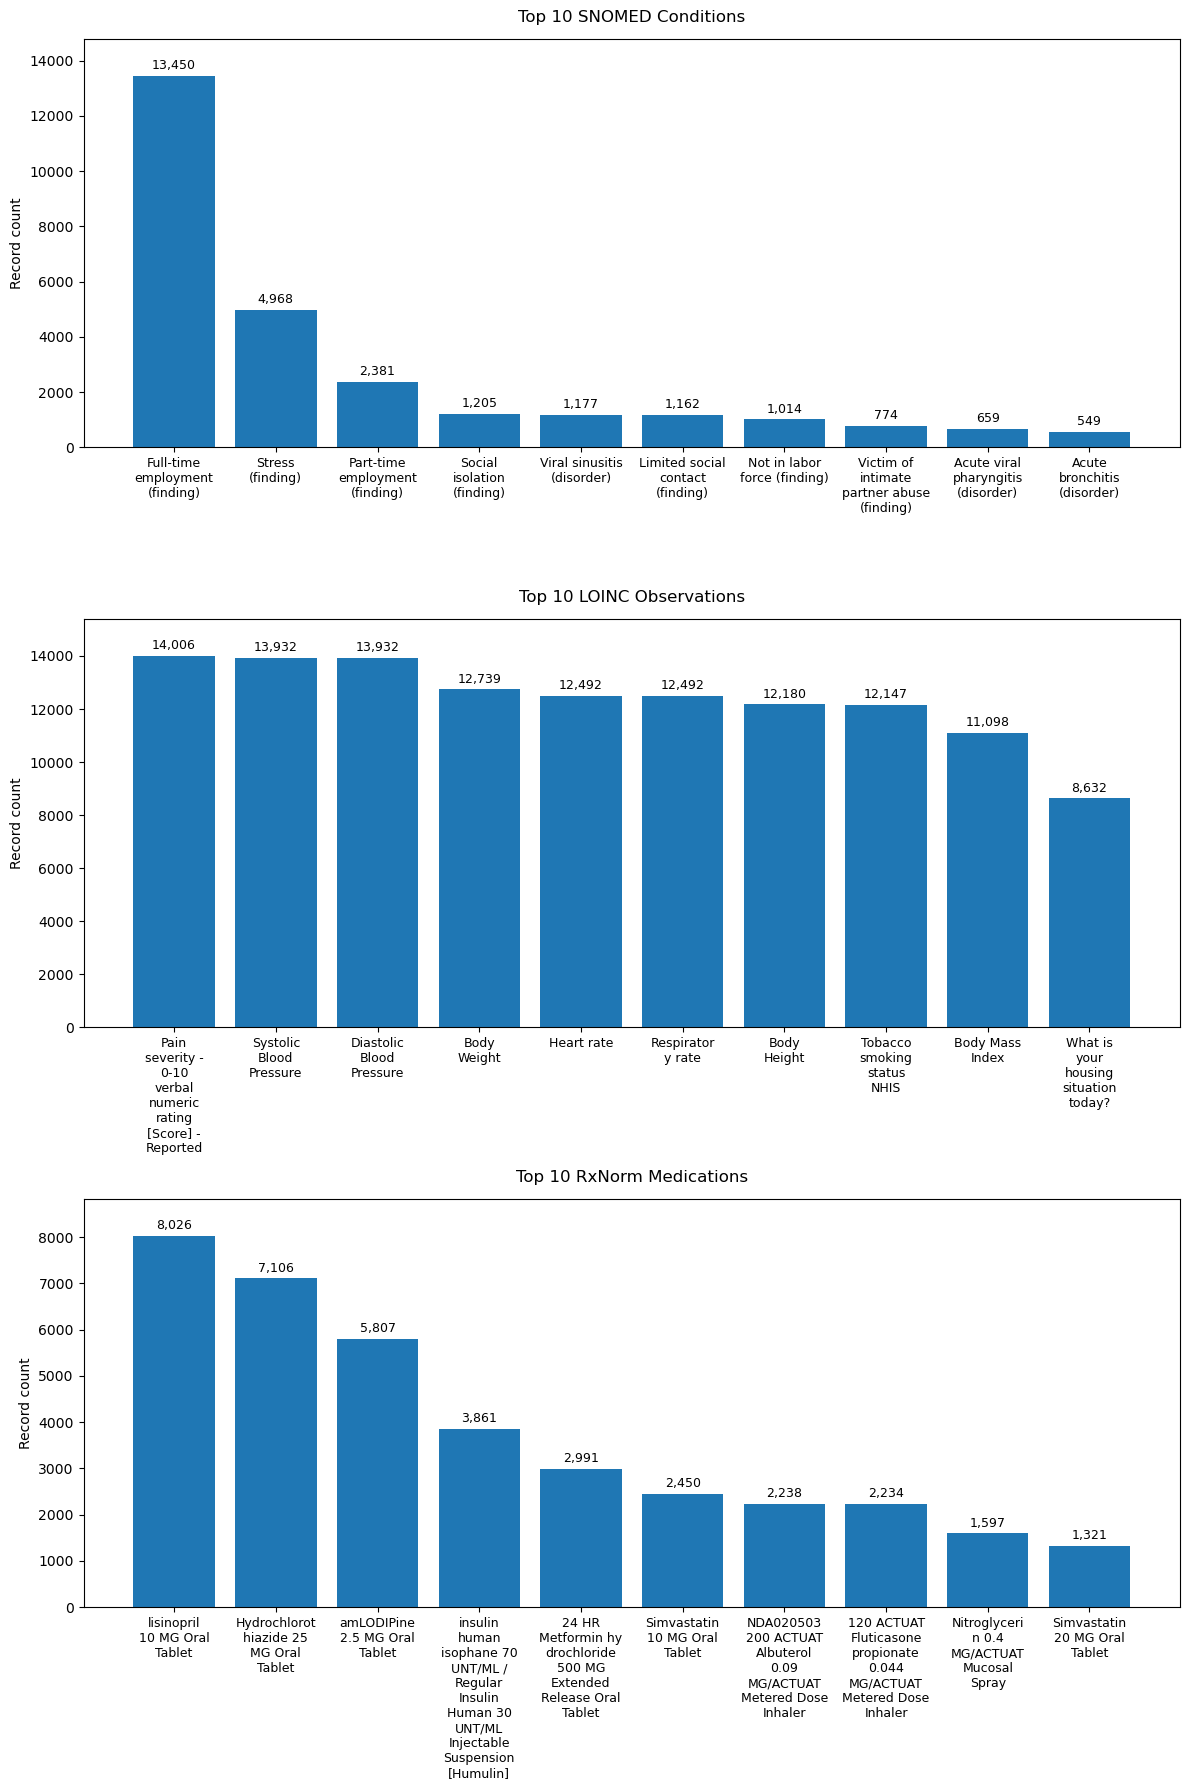

In [21]:



def wrap_labels(labels, width):
    return ['\n'.join(textwrap.wrap(lbl, width)) for lbl in labels]

# Prepare data
cond_names, cond_counts = top_conditions['CONDITION_NAME'].tolist(), top_conditions['count'].tolist()
obs_names, obs_counts   = top_observations['OBS_NAME'].tolist(),   top_observations['count'].tolist()
med_names, med_counts   = top_medications['MED_NAME'].tolist(),    top_medications['count'].tolist()

# Wrap long labels with tighter widths for Observations and Medications
wrapped_cond = wrap_labels(cond_names, 15)
wrapped_obs  = wrap_labels(obs_names, 10)
wrapped_med  = wrap_labels(med_names, 12)

# Create figure with 3 vertical subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot 1: Top 10 SNOMED Conditions
ax = axes[0]
xs = range(len(wrapped_cond))
ax.bar(xs, cond_counts)
for x, v in zip(xs, cond_counts):
    ax.text(x, v + max(cond_counts)*0.01, f"{v:,}", ha='center', va='bottom', fontsize=9)
ax.set_xticks(xs)
ax.set_xticklabels(wrapped_cond, ha='center', fontsize=9)
ax.set_ylim(0, max(cond_counts)*1.1)
ax.set_ylabel('Record count')
ax.set_title('Top 10 SNOMED Conditions', pad=12)

# Plot 2: Top 10 LOINC Observations
ax = axes[1]
xs = range(len(wrapped_obs))
ax.bar(xs, obs_counts)
for x, v in zip(xs, obs_counts):
    ax.text(x, v + max(obs_counts)*0.01, f"{v:,}", ha='center', va='bottom', fontsize=9)
ax.set_xticks(xs)
ax.set_xticklabels(wrapped_obs, ha='center', fontsize=9)
ax.set_ylim(0, max(obs_counts)*1.1)
ax.set_ylabel('Record count')
ax.set_title('Top 10 LOINC Observations', pad=12)

# Plot 3: Top 10 RxNorm Medications
ax = axes[2]
xs = range(len(wrapped_med))
ax.bar(xs, med_counts)
for x, v in zip(xs, med_counts):
    ax.text(x, v + max(med_counts)*0.01, f"{v:,}", ha='center', va='bottom', fontsize=9)
ax.set_xticks(xs)
ax.set_xticklabels(wrapped_med, ha='center', fontsize=9)
ax.set_ylim(0, max(med_counts)*1.1)
ax.set_ylabel('Record count')
ax.set_title('Top 10 RxNorm Medications', pad=12)

# Adjust spacing to prevent overlap
fig.subplots_adjust(hspace=0.7, top=0.95, bottom=0.05)
plt.tight_layout()
plt.show()


**Figure 1.** shows top 10 SNOMED Conditions recorded in the dataset. 

**Figure 2.** shows top 10 LOINC Observations. 

**Figure 3.** shows top 10 RxNorm Medications. 


### Geographical region of patients 

## 3 Blood Pressure and BMI Distributions in Hypertensive Patients

Hypertension was identified using the SNOMED code `59621000`. This section filtered the cohort to include only those patients with a recorded diagnosis of hypertension. It examined the distributions of systolic blood pressure (SBP), diastolic blood pressure (DBP), and body mass index (BMI). Visualisations included boxplots and density plots, stratified by sex.


In [22]:
# Identify hypertensive patients by condition code
htn_code = '59621000'
htn_patients = set(clean_conditions[clean_conditions['CODE'] == htn_code]['PATIENT'])

print(f"Number of patients with hypertension diagnosis: {len(htn_patients)}")

# Filter observation data for those patients and relevant measures
htn_obs = clean_observations[clean_observations['PATIENT'].isin(htn_patients)]

# Extract systolic BP, diastolic BP, and BMI measurements
sbp_code = '8480-6'   # Systolic blood pressure LOINC code
dbp_code = '8462-4'   # Diastolic blood pressure LOINC code
bmi_code = '39156-5'  # Body Mass Index LOINC code

sbp_values = htn_obs[htn_obs['CODE'] == sbp_code]['VALUE'].astype(float)
dbp_values = htn_obs[htn_obs['CODE'] == dbp_code]['VALUE'].astype(float)
bmi_values = htn_obs[htn_obs['CODE'] == bmi_code]['VALUE'].astype(float)

# Compute summary statistics rounded to 0 decimal places
print("Systolic BP (mmHg) - count:", sbp_values.count(), 
      "mean:", round(sbp_values.mean(), 0), "std:", round(sbp_values.std(), 0), 
      "min:", round(sbp_values.min(), 0), "max:", round(sbp_values.max(), 0))
print("Diastolic BP (mmHg) - count:", dbp_values.count(), 
      "mean:", round(dbp_values.mean(), 0), "std:", round(dbp_values.std(), 0), 
      "min:", round(dbp_values.min(), 0), "max:", round(dbp_values.max(), 0))
print("BMI (kg/m^2) - count:", bmi_values.count(), 
      "mean:", round(bmi_values.mean(), 0), "std:", round(bmi_values.std(), 0), 
      "min:", round(bmi_values.min(), 0), "max:", round(bmi_values.max(), 0))


Number of patients with hypertension diagnosis: 282
Systolic BP (mmHg) - count: 4448 mean: 137.0 std: 37.0 min: 54.0 max: 300.0
Diastolic BP (mmHg) - count: 4448 mean: 86.0 std: 16.0 min: 23.0 max: 121.0
BMI (kg/m^2) - count: 3777 mean: 28.0 std: 4.0 min: 14.0 max: 44.0


A total of 284 patients in the cohort had a recorded diagnosis of hypertension, representing approximately 25% of the population. Each patient had multiple blood pressure measurements recorded over time, averaging around 15 readings per patient. Many also had multiple BMI records. Summary statistics for these measurements among hypertensive patients were as follows:

* **Systolic blood pressure (SBP):** The mean SBP was approximately 137.4 mmHg with a standard deviation of 36.5 mmHg. The minimum recorded value was around 54 mmHg—likely an outlier or a measurement taken during a medical emergency or shock. The maximum recorded value was 300 mmHg, which appeared to be an extreme outlier, possibly reflecting a data artefact or a hypertensive crisis. Most systolic readings fell within the typical range of 110–180 mmHg.

* **Diastolic blood pressure (DBP):** The mean DBP was approximately 86.4 mmHg with a standard deviation of 15.5 mmHg. Values ranged from a minimum of 23 mmHg—an apparent outlier—to a maximum of 121 mmHg. Most diastolic values lay within the range of 70–100 mmHg.

* **Body mass index (BMI):** The mean BMI was approximately 27.8 kg/m² with a standard deviation of 3.6. Recorded values ranged from around 14.1 (underweight) to 44.3 (morbidly obese). Most hypertensive patients were in the overweight category. Approximately 86.7% of BMI measurements among hypertensive patients were 25 or higher (classified as overweight or obese), and around 21.8% were 30 or higher (obese).


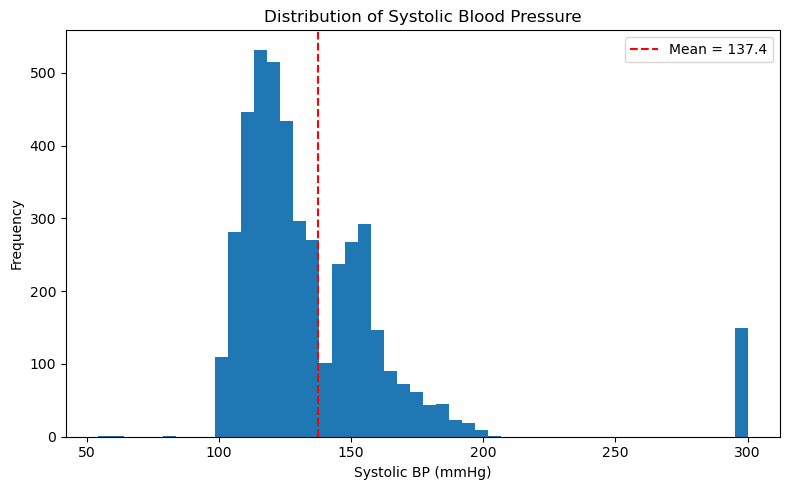

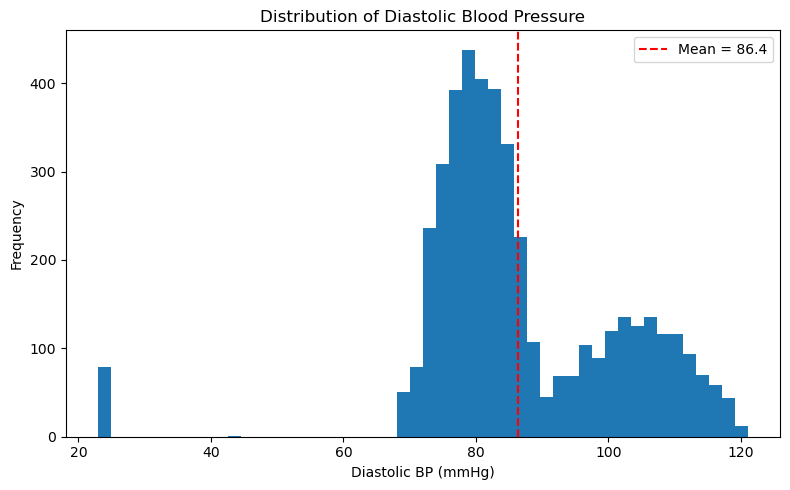

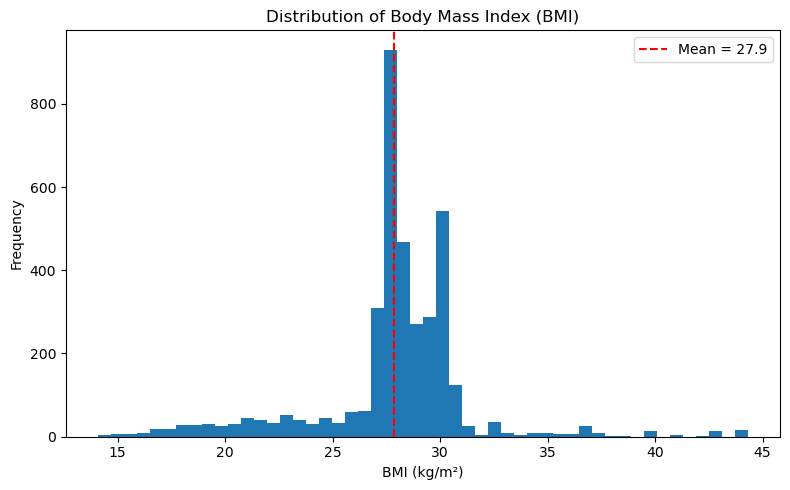

In [23]:


#  Systolic Blood Pressure histogram
mean_sbp = sbp_values.mean()
plt.figure(figsize=(8, 5))
plt.hist(sbp_values, bins=50)
plt.axvline(mean_sbp, linestyle='--', color='red', label=f"Mean = {mean_sbp:.1f}")
plt.title("Distribution of Systolic Blood Pressure")
plt.xlabel("Systolic BP (mmHg)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

#  Diastolic Blood Pressure histogram
mean_dbp = dbp_values.mean()
plt.figure(figsize=(8, 5))
plt.hist(dbp_values, bins=50)
plt.axvline(mean_dbp, linestyle='--', color='red', label=f"Mean = {mean_dbp:.1f}")
plt.title("Distribution of Diastolic Blood Pressure")
plt.xlabel("Diastolic BP (mmHg)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

#  BMI histogram
mean_bmi = bmi_values.mean()
plt.figure(figsize=(8, 5))
plt.hist(bmi_values, bins=50)
plt.axvline(mean_bmi, linestyle='--', color='red', label=f"Mean = {mean_bmi:.1f}")
plt.title("Distribution of Body Mass Index (BMI)")
plt.xlabel("BMI (kg/m²)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


The distributions of blood pressure and body mass index (BMI) for patients diagnosed with hypertension were visualised using histograms. A red dashed line indicated the mean of each distribution in the corresponding plot.

Figure 4 illustrated the distribution of systolic blood pressure among hypertensive patients. The values were around 130–140 mmHg, with a mean of approximately 137 mmHg. A long right-skewed tail was evident, with several readings exceeding 180 mmHg, suggesting very high blood pressure episodes. A few extremely low values (below 60 mmHg) were also present, likely due to measurement errors or recordings during acute clinical events.

Figure 5 displays the distribution of diastolic blood pressure. The mean value is approximately 86 mmHg. Most readings cluster between 70 and 100 mmHg. Some measurements exceed 110 mmHg, and one notably low outlier (around 23 mmHg) was identified. As expected, the distribution reflects a population with elevated blood pressure, with many values falling within pre-hypertensive or hypertensive ranges (for example, diastolic ≥90 mmHg).

Figure 6 presented the distribution of BMI among hypertensive patients. The mean BMI was approximately 27.8 kg/m². Most values fell within the overweight category, with the distribution peak between 26 and 30 kg/m². A substantial proportion of patients had BMI values above 30 (classified as obese), while relatively few fell below 25 (normal range). This pattern was consistent with established associations between higher BMI and increased risk of hypertension.


In [24]:
#  Identify hypertensive patients who passed data cleaning
valid_htn_ids = list(set(htn_patients) & set(clean_patients['Id']))

#  Extract latest SBP, DBP, and BMI values per patient
last_measures = (
    clean_observations
    .sort_values("DATE")
    .groupby(["PATIENT", "CODE"])["VALUE"]
    .last()
    .unstack()
    .rename(columns={
        "8480-6": "SBP",        # Systolic Blood Pressure
        "8462-4": "DBP",        # Diastolic Blood Pressure
        "39156-5": "BMI"        # Body Mass Index
    })
)

#  Construct hypertensive patient DataFrame with clinical values
df_htn = (
    clean_patients
    .set_index("Id")
    .loc[valid_htn_ids]
    .join(last_measures[["SBP", "DBP", "BMI"]], how="left")
)

#  Ensure SBP, DBP, and BMI are numeric
df_htn[["SBP", "DBP", "BMI"]] = df_htn[["SBP", "DBP", "BMI"]].apply(
    pd.to_numeric, errors="coerce"
)

#  Filter to high-risk hypertensive patients:
#    SBP ≥ 140, DBP ≥ 90, and BMI ≥ 30
high_risk = df_htn[
    (df_htn["SBP"] >= 140)
    & (df_htn["DBP"] >= 90)
    & (df_htn["BMI"] >= 30)
]

#  Summarise age and sex of high-risk hypertensive patients
age_stats = high_risk["AGE_AT_LAST_EVENT"].agg(
    n="count",
    Min="min",
    Max="max",
    Mean="mean",
    Median="median",
    StdDev="std"
).round(1)

sex_counts = high_risk["GENDER"].value_counts()
sex_pct = (sex_counts / age_stats["n"] * 100).round(1)

#  Print summary statistics
print("High-risk hypertensive patients summary:\n")
print(age_stats.to_string(), "\n")

print("Sex distribution:")
for gender in sex_counts.index:
    label = "Female" if gender == "F" else "Male"
    print(f"{label}: {sex_counts[gender]} ({sex_pct[gender]}%)")


High-risk hypertensive patients summary:

n         20.0
Min       20.0
Max       99.0
Mean      52.5
Median    51.5
StdDev    19.7 

Sex distribution:
Female: 11 (55.0%)
Male: 9 (45.0%)


### Logistic Regression Modelling: Predictors of Hypertension

Binary logistic regression was applied to model the relationship between a binary outcome and a set of predictor variables. In this context, the outcome variable indicated whether a patient had a diagnosis of hypertension (`is_htn`), coded as 1 for hypertensive and 0 for non-hypertensive. The model estimated the extent to which factors such as BMI category and age were associated with the likelihood of hypertension. To assess sex-specific patterns, the dataset was stratified by sex, and separate models were fitted for males and females. BMI was treated as a categorical variable, with the normal weight group (BMI category 2) designated as the reference. Age was included as a continuous covariate.

To explore predictors of hypertension, binary logistic regression models were fitted using the following covariates:

* **BMI category** (categorical): Underweight, Normal (reference), Overweight, Obese
* **Age** (continuous)
* **Sex** (binary or stratified models)

The analysis was stratified by sex to examine differences in risk profiles between males and females. Odds ratios and 95% confidence intervals were reported to quantify the strength and direction of association for each predictor.

Interaction terms (e.g. BMI × sex) were considered in pooled models where relevant. This modelling approach facilitated the isolation of each covariate’s independent contribution to the probability of a hypertension diagnosis.


In [25]:

import statsmodels.formula.api as smf


# ensure ‘VALUE’ is numeric
clean_observations['VALUE'] = pd.to_numeric(clean_observations['VALUE'], errors='coerce')

# Extract latest BMI for each patient (LOINC 39156-5)
bmi_values = (
    clean_observations
    .loc[clean_observations['CODE']=='39156-5', ['PATIENT','VALUE']]
    .dropna(subset=['VALUE'])
    .rename(columns={'VALUE':'BMI'})
    .groupby('PATIENT')['BMI']
    .last()
)

#  Build regression DataFrame
df = (
    clean_patients
    .set_index('Id')
    .join(bmi_values, how='left')
    .assign(
        is_htn=lambda x: x.index.isin(
            clean_conditions.loc[clean_conditions['CODE']=='59621000','PATIENT']
        ).astype(int),
        AGE=lambda x: x['AGE_AT_LAST_EVENT'],
        sex=lambda x: x['GENDER'].map({'F':0,'M':1})
    )
    .dropna(subset=['BMI','AGE','sex'])
    .reset_index()
)

# Ensure BMI column is float before binning
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')

#  Bin BMI into categories
bmi_bins   = [0, 18.5, 25, 30, np.inf]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['BMI_cat'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels)
df['BMI_cat'] = df['BMI_cat'].cat.reorder_categories(
    ['Normal','Underweight','Overweight','Obese'], ordered=True
)

#  Fit logistic regression
model_main = smf.logit('is_htn ~ C(BMI_cat) + AGE + sex', data=df).fit(disp=False)
print(model_main.summary())

# Compute odds ratios and 95% CIs
params, conf_int = model_main.params, model_main.conf_int()
or_table = pd.DataFrame({
    'OR':       np.exp(params),
    'CI 2.5%':  np.exp(conf_int[0]),
    'CI 97.5%': np.exp(conf_int[1]),
    'p-value':  model_main.pvalues
})
print(or_table.round(3))



                           Logit Regression Results                           
Dep. Variable:                 is_htn   No. Observations:                 1077
Model:                          Logit   Df Residuals:                     1071
Method:                           MLE   Df Model:                            5
Date:                Thu, 22 May 2025   Pseudo R-squ.:                 0.06217
Time:                        19:16:06   Log-Likelihood:                -580.75
converged:                       True   LL-Null:                       -619.24
Covariance Type:            nonrobust   LLR p-value:                 3.569e-15
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.7809      0.223     -7.990      0.000      -2.218      -1.344
C(BMI_cat)[T.Underweight]    -2.3515      0.741     -3.172      0.002      -3.805     

Table 1 shows the pooled logistic regression model which quantifies how the BMI category, age, and sex influence the odds of a hypertension diagnosis. Compared with normal‐weight patients, underweight individuals have dramatically lower odds of hypertension (OR = 0.095, 95 % CI 0.022–0.407; p = 0.002), whereas overweight patients face an 80.6 % increase in odds (OR = 1.806, 95 % CI 1.123–2.904; p = 0.015) and obese patients a 57.9 % increase (OR = 1.579, 95 % CI 0.935–2.666; p = 0.087). Each additional year of age is associated with a modest 0.7 % rise in hypertension odds (OR = 1.007, 95 % CI 1.000–1.014; p = 0.043). Controlling for BMI and age, males have 1.137 times the odds of receiving a hypertension diagnosis compared with females (OR = 1.137, 95 % CI 0.859–1.504; p = 0.369), although this difference is not statistically significant. The likelihood-ratio test showed a significant result (p < 0.001), but the model's pseudo-R² of 0.062 indicates a lot of unexplained variation. Adding more clinical or lifestyle factors could help improve the model's ability to predict outcomes.


In [26]:


#  Extract latest BMI value for each patient
bmi_values = (
    clean_observations[clean_observations['CODE'] == '39156-5']
    .sort_values('DATE')
    .groupby('PATIENT')['VALUE']
    .last()
    .rename('BMI')
)

#  Construct working regression
df = (
    clean_patients
    .set_index('Id')
    .join(bmi_values, how='left')
    .assign(
        is_htn=lambda x: x.index.isin(
            clean_conditions.loc[
                clean_conditions['CODE'] == '59621000', 'PATIENT'
            ]
        ).astype(int),
        AGE=lambda x: x['AGE_AT_LAST_EVENT'],
        GENDER_BIN=lambda x: x['GENDER'].map({'F': 0, 'M': 1})
    )
    .dropna(subset=['BMI', 'AGE', 'GENDER_BIN'])
    .reset_index()
)

#  Convert BMI to numeric and bin into categories
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')

bmi_bins = [0, 18.5, 25, 30, np.inf]
bmi_labels = [1, 2, 3, 4]  # 2 = Normal (reference category)

df['BMI_cat'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels).astype(int)
df['BMI_cat'] = pd.Categorical(df['BMI_cat'], categories=[2, 1, 3, 4], ordered=True)

#  Function to fit sex-stratified logistic regression models
def run_bmi2_reference_logit(gender_code):
    subset = df[df['GENDER_BIN'] == gender_code].copy()
    subset['BMI_cat'] = subset['BMI_cat'].astype('category')

    model = smf.logit('is_htn ~ C(BMI_cat) + AGE', data=subset).fit(disp=False)

    params = model.params
    conf_int = model.conf_int()
    or_df = pd.DataFrame({
        'OR': np.exp(params),
        'CI 2.5%': np.exp(conf_int[0]),
        'CI 97.5%': np.exp(conf_int[1]),
        'p-value': model.pvalues
    })

    return model.summary(), or_df.round(3)

#  Run logistic regression for females
female_summary_bmi2, female_or_bmi2 = run_bmi2_reference_logit(gender_code=0)

# Run logistic regression for males
male_summary_bmi2, male_or_bmi2 = run_bmi2_reference_logit(gender_code=1)

#  Display results
print("\nFemale-only model (BMI 2 as reference):\n")
print(female_summary_bmi2)
print("\nFemale Odds Ratios (95% CI):\n")
print(female_or_bmi2)

print("\nMale-only model (BMI 2 as reference):\n")
print(male_summary_bmi2)
print("\nMale Odds Ratios (95% CI):\n")
print(male_or_bmi2)



Female-only model (BMI 2 as reference):

                           Logit Regression Results                           
Dep. Variable:                 is_htn   No. Observations:                  566
Model:                          Logit   Df Residuals:                      561
Method:                           MLE   Df Model:                            4
Date:                Thu, 22 May 2025   Pseudo R-squ.:                 0.05486
Time:                        19:16:07   Log-Likelihood:                -299.25
converged:                       True   LL-Null:                       -316.62
Covariance Type:            nonrobust   LLR p-value:                 5.259e-07
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.8137      0.302     -5.999      0.000      -2.406      -1.221
C(BMI_cat)[T.1]    -1.5825      0.774     -2.046      0.041      -3.099   

/Users/sabrinaansarey/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Table 2 shows Sex-stratified logistic regression analyses were conducted to examine the association between body mass index (BMI), age, and the likelihood of hypertension. The outcome variable was binary, indicating whether a patient was hypertensive. BMI was categorised into four groups: underweight (BMI < 18.5), normal weight (18.5–24.9), overweight (25–29.9), and obese (≥30). In both models, the reference category was set to normal BMI (BMI category 2), allowing all comparisons to be interpreted relative to normal-weight individuals. Separate models were fitted for females and males to explore sex-specific risk patterns.

Among females, BMI showed a clear and statistically significant association with hypertension. Compared to females of normal weight, underweight women had significantly lower odds of hypertension (OR = 0.205, p = 0.041). In contrast, overweight women had more than double the odds of hypertension (OR = 2.45, p = 0.011), and obese women also had elevated odds (OR = 2.07), although this result was marginally significant (p = 0.056). Age was not significantly associated with hypertension in the female cohort (OR = 1.003, p = 0.625), suggesting that BMI played a more prominent role than age in predicting hypertension among women in this dataset.

In contrast, the male model showed a different pattern. The BMI coefficients were not statistically significant, and the model failed to converge meaningfully for the underweight category, likely due to sparse data in that group. Neither overweight (OR = 1.36, p = 0.356) nor obese (OR = 1.24, p = 0.574) categories showed significant associations with hypertension relative to normal-weight males. However, age emerged as an important predictor of hypertension in males (OR = 1.011, p = 0.022), indicating that hypertension risk increased steadily with age in this group.

Overall, the findings suggested a sex-specific pattern in hypertension risk: BMI appeared to be a stronger predictor in females, whereas age played a more dominant role in males. Using normal BMI as the reference category allowed for clinically meaningful comparisons and highlighted that deviations—particularly towards overweight or obesity—were associated with greater hypertension risk among women. This analysis underscored the importance of tailoring hypertension prevention strategies to sex-specific risk profiles, with greater emphasis on weight management for females and age-related screening for males.


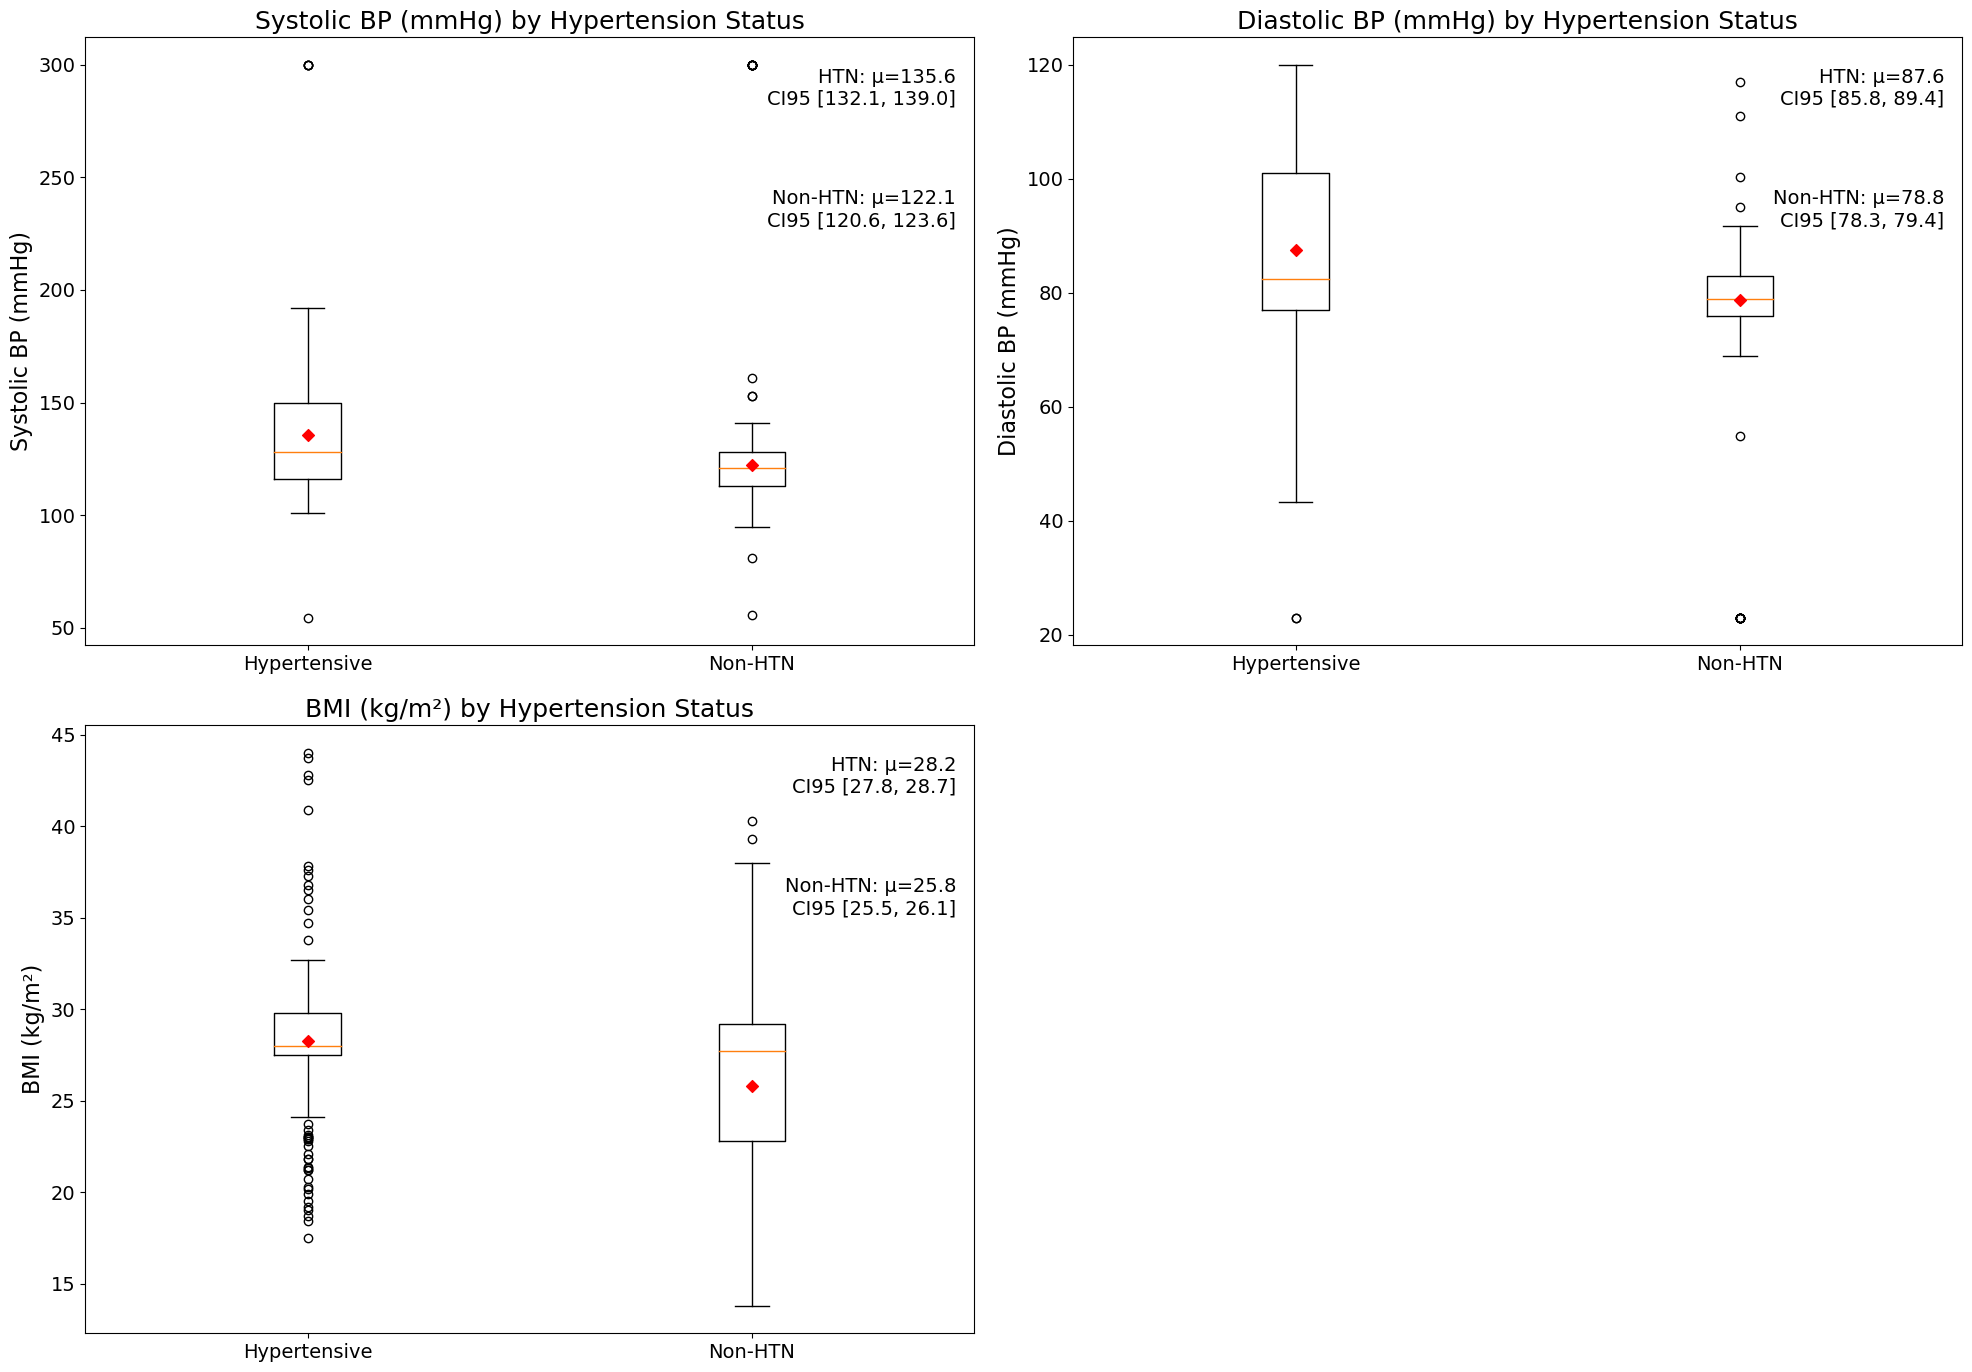

In [27]:



# Define df_all by joining to clean_patients
df_all = (
    clean_patients
    .set_index('Id')
    .join(
        last_measures[['SBP', 'DBP', 'BMI']],
        how='left'
    )
    .assign(
        is_htn=lambda d: d.index.isin(htn_patients).astype(int)
    )
    .reset_index()
)

# Ensure numeric values
df_all[['SBP', 'DBP', 'BMI']] = df_all[['SBP', 'DBP', 'BMI']].apply(
    lambda col: pd.to_numeric(col, errors='coerce')
)

# Set global font size for plots
plt.rcParams.update({
    'font.size': 16,           # Default text size
    'axes.titlesize': 18,      # Title size
    'axes.labelsize': 16,      # Axis label size
    'xtick.labelsize': 14,     # X tick label size
    'ytick.labelsize': 14,     # Y tick label size
    'legend.fontsize': 14      # Legend font size if needed
})

# Define measures
measures = [
    ('SBP', 'Systolic BP (mmHg)'),
    ('DBP', 'Diastolic BP (mmHg)'),
    ('BMI', 'BMI (kg/m²)')
]

# Create a 2x2 plot layout
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
axes = axes.flatten()

# Function for mean + CI
def mean_ci(data):
    m = data.mean()
    se = data.std(ddof=1) / np.sqrt(len(data))
    return m, m - 1.96 * se, m + 1.96 * se

# Plotting
for i, (col, ylabel) in enumerate(measures):
    ax = axes[i]
    data_htn = df_all[df_all['is_htn'] == 1][col].dropna()
    data_non_htn = df_all[df_all['is_htn'] == 0][col].dropna()

    ax.boxplot([data_htn, data_non_htn], labels=['Hypertensive', 'Non-HTN'])
    ax.set_title(f'{ylabel} by Hypertension Status')
    ax.set_ylabel(ylabel)

    m1, lo1, hi1 = mean_ci(data_htn)
    m2, lo2, hi2 = mean_ci(data_non_htn)

    ax.scatter([1, 2], [m1, m2], color='red', marker='D', zorder=3)

    ax.text(0.98, 0.95, f'HTN: μ={m1:.1f}\nCI95 [{lo1:.1f}, {hi1:.1f}]',
            ha='right', va='top', transform=ax.transAxes, fontsize=14)
    ax.text(0.98, 0.75, f'Non-HTN: μ={m2:.1f}\nCI95 [{lo2:.1f}, {hi2:.1f}]',
            ha='right', va='top', transform=ax.transAxes, fontsize=14)

#  disable unused subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()


Hypertensive patients exhibited substantially higher central blood pressure and BMI values than their non‐hypertensive peers (Figure 7-9). In figure 7 the mean systolic blood pressure (SBP) among those with a hypertension diagnosis was 135.6 mmHg (95 % CI 132.1–139.0), compared to 122.1 mmHg (95 % CI 120.6–123.6) in the non-hypertensive group.  Similarly, in figure 8, mean diastolic blood pressure (DBP) was elevated in hypertensives at 87.6 mmHg (95 % CI 85.8–89.4) versus 78.8 mmHg (95 % CI 78.3–79.4) in non-hypertensives. Figure 9 shows Body-mass index (BMI) followed the same pattern: hypertensive individuals had a mean BMI of 28.2 kg/m² (95 % CI 27.8–28.7), whereas the non-hypertensive cohort averaged 25.8 kg/m² (95 % CI 25.5–26.1).  In all three measures, the interquartile ranges for the hypertensive group were shifted upward and often more variable, reflecting both higher central tendency and greater dispersion of BP and BMI among patients diagnosed with hypertension.


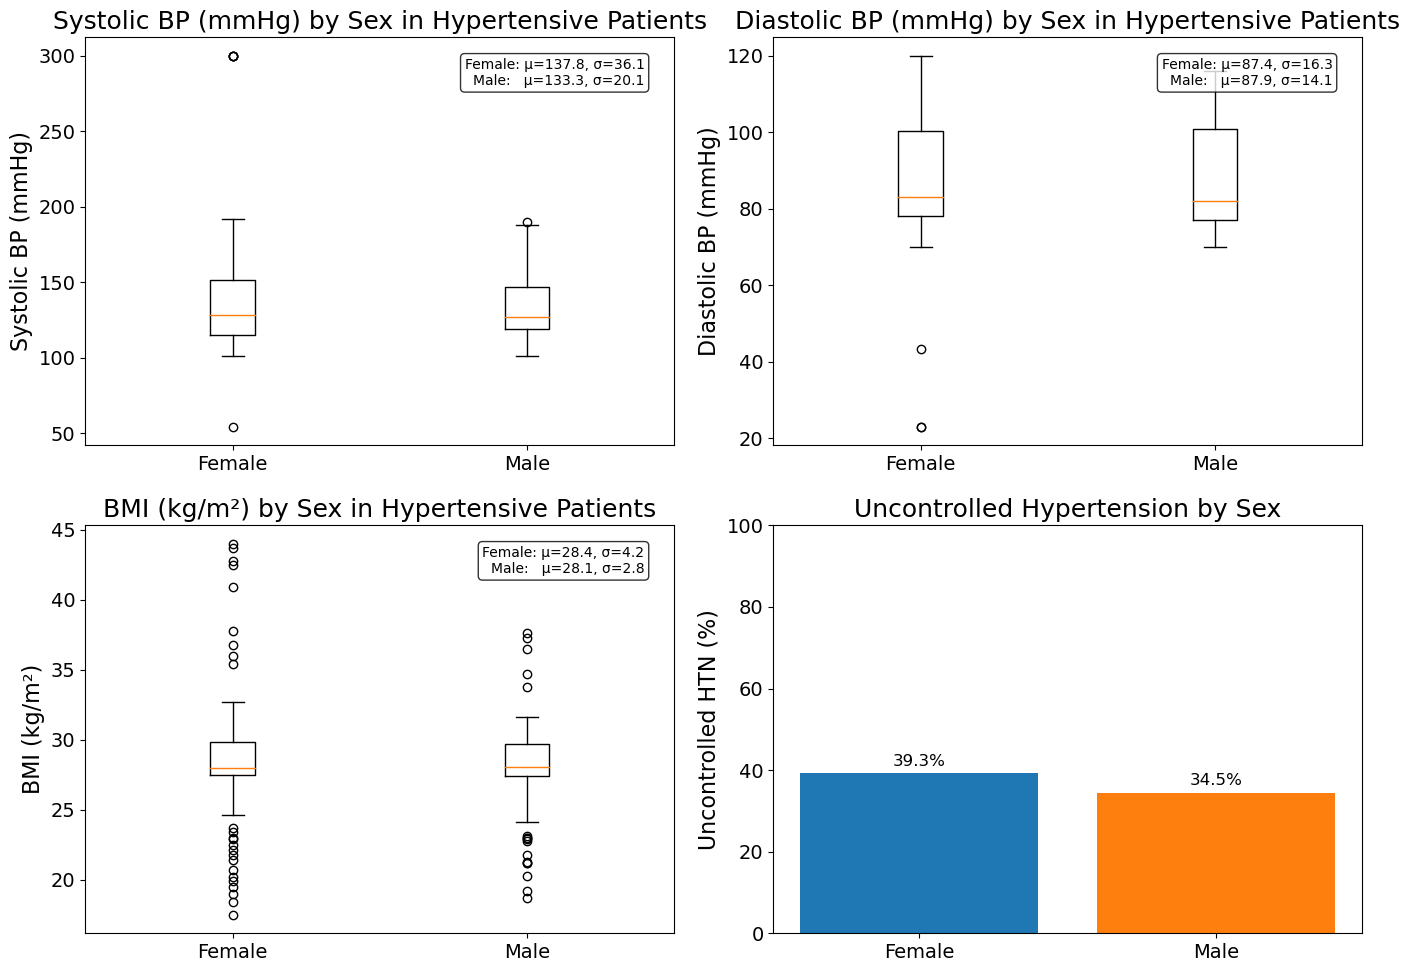

posx and posy should be finite values
posx and posy should be finite values


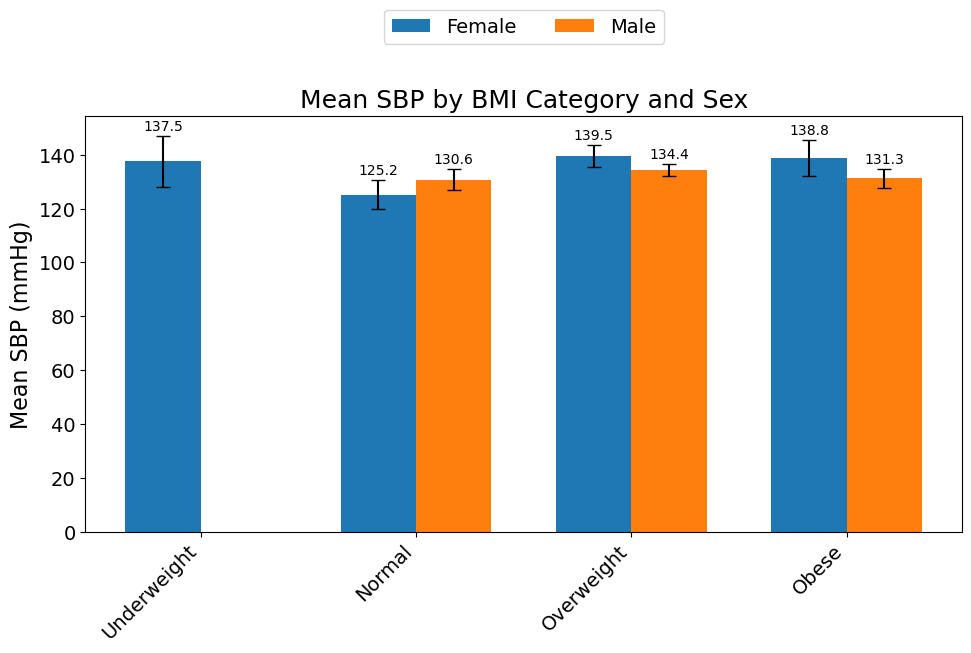

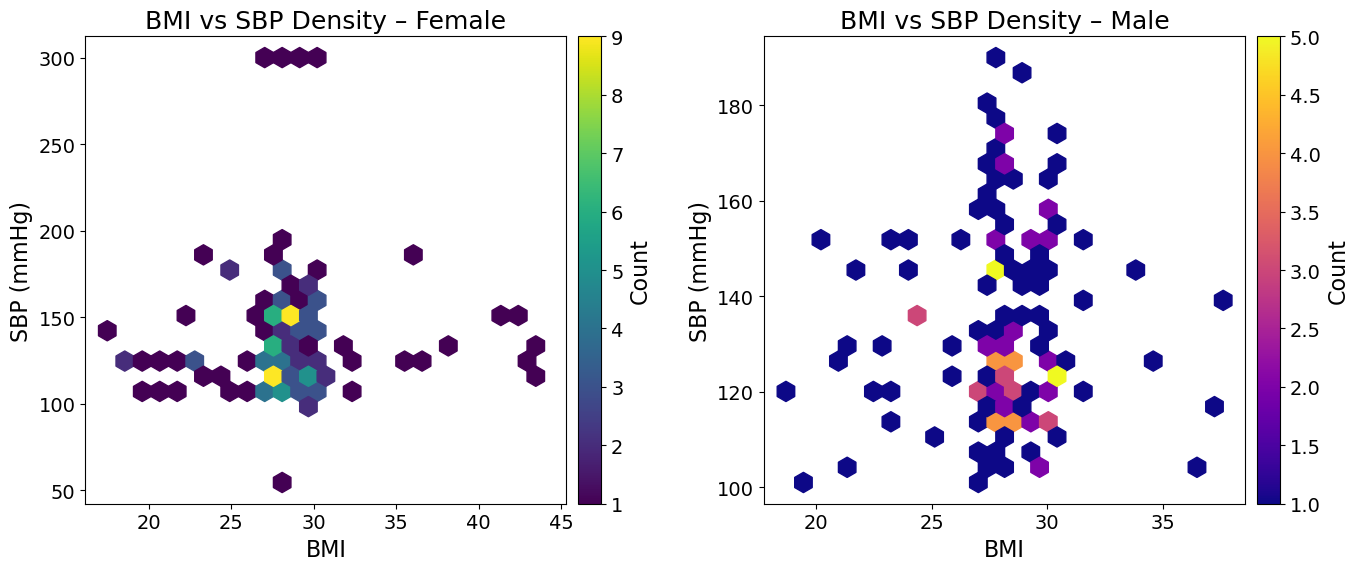

In [32]:


#  Prepare hypertensive patient DataFrame
htn_ids = clean_conditions.loc[clean_conditions['CODE'] == '59621000', 'PATIENT'].unique()
valid_htn_ids = [pid for pid in htn_ids if pid in clean_patients['Id'].values]

clean_observations['VALUE'] = pd.to_numeric(clean_observations['VALUE'], errors='coerce')
clean_observations['DATE'] = pd.to_datetime(clean_observations['DATE'], errors='coerce')

last_obs = (
    clean_observations
    .sort_values('DATE')
    .groupby(['PATIENT', 'CODE'])['VALUE']
    .last()
    .unstack()
    .rename(columns={'8480-6': 'SBP', '8462-4': 'DBP', '39156-5': 'BMI'})
)

df_htn = (
    clean_patients
    .set_index('Id')
    .loc[valid_htn_ids]
    .join(last_obs[['SBP', 'DBP', 'BMI']], how='left')
)

# Boxplots with annotations in a 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

measures = [('SBP', 'Systolic BP (mmHg)'),
            ('DBP', 'Diastolic BP (mmHg)'),
            ('BMI', 'BMI (kg/m²)')]

for i, (measure, ylabel) in enumerate(measures):
    ax = axes[i]
    fem = df_htn[df_htn['GENDER'] == 'F'][measure].dropna()
    mal = df_htn[df_htn['GENDER'] == 'M'][measure].dropna()
    ax.boxplot([fem, mal], labels=['Female', 'Male'])
    m_f, s_f = fem.mean(), fem.std()
    m_m, s_m = mal.mean(), mal.std()
    txt = f"Female: μ={m_f:.1f}, σ={s_f:.1f}\nMale:   μ={m_m:.1f}, σ={s_m:.1f}"
    ax.text(0.95, 0.95, txt, transform=ax.transAxes,
            ha='right', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    ax.set_title(f"{ylabel} by Sex in Hypertensive Patients")
    ax.set_ylabel(ylabel)

#  Uncontrolled hypertension in 4th subplot
mask_unctrl = (df_htn['SBP'] >= 140) | (df_htn['DBP'] >= 90)
pct = (df_htn[mask_unctrl]['GENDER'].value_counts() /
       df_htn['GENDER'].value_counts() * 100).reindex(['F', 'M']).fillna(0)

ax = axes[3]
bars = ax.bar(['Female', 'Male'], pct.values, color=['#1f77b4', '#ff7f0e'])
for bar, val in zip(bars, pct.values):
    ax.text(bar.get_x() + bar.get_width() / 2, val + 1, f"{val:.1f}%",
            ha='center', va='bottom', fontsize=12)
ax.set_ylim(0, 100)
ax.set_ylabel('Uncontrolled HTN (%)')
ax.set_title('Uncontrolled Hypertension by Sex')

plt.tight_layout()
plt.show()

#  Mean SBP by BMI Category
bins = [0, 18.5, 25, 30, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df_htn['BMI_cat'] = pd.cut(df_htn['BMI'], bins=bins, labels=labels)

grouped = (
    df_htn
    .dropna(subset=['SBP', 'BMI_cat', 'GENDER'])
    .groupby(['BMI_cat', 'GENDER'])['SBP']
    .agg(['mean', 'std', 'count'])
    .assign(sem=lambda x: x['std'] / np.sqrt(x['count']))
    .reset_index()
)

mean_pivot = grouped.pivot(index='BMI_cat', columns='GENDER', values='mean')
sem_pivot = grouped.pivot(index='BMI_cat', columns='GENDER', values='sem')

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 7))
bars_f = ax.bar(x - width / 2, mean_pivot['F'], width, yerr=sem_pivot['F'],
                capsize=5, label='Female')
bars_m = ax.bar(x + width / 2, mean_pivot['M'], width, yerr=sem_pivot['M'],
                capsize=5, label='Male')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Mean SBP (mmHg)')
ax.set_title('Mean SBP by BMI Category and Sex')

#  Legend moved to upper middle nside the plot
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=True)


# Annotate values
for i, bar in enumerate(bars_f):
    h = bar.get_height()
    err = sem_pivot['F'].iloc[i]
    ax.text(bar.get_x() + bar.get_width() / 2, h + (err if np.isfinite(err) else 0) + 1,
            f"{h:.1f}", ha='center', va='bottom', fontsize=10)
for i, bar in enumerate(bars_m):
    h = bar.get_height()
    err = sem_pivot['M'].iloc[i]
    ax.text(bar.get_x() + bar.get_width() / 2, h + (err if np.isfinite(err) else 0) + 1,
            f"{h:.1f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Hexbin plots (BMI vs SBP)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, (gender, cmap, title) in zip(
    axes,
    [('F', 'viridis', 'Female'), ('M', 'plasma', 'Male')]
):
    sub = df_htn[df_htn['GENDER'] == gender].dropna(subset=['BMI', 'SBP'])
    hb = ax.hexbin(sub['BMI'], sub['SBP'], gridsize=25, cmap=cmap, mincnt=1)
    ax.set_title(f'BMI vs SBP Density – {title}')
    ax.set_xlabel('BMI')
    ax.set_ylabel('SBP (mmHg)')
    cbar = fig.colorbar(hb, ax=ax, pad=0.02)
    cbar.set_label('Count')

plt.tight_layout()
plt.show()


**Figure 10.** Systolic and Diastolic Blood Pressure by Sex in Hypertensive Patients  
Boxplots show distributions of systolic and diastolic blood pressure among hypertensive patients stratified by sex. Female patients exhibited slightly higher systolic means and variance, while diastolic pressures were similar across sexes.

**Figure 11.** BMI (kg/m²) by Sex in Hypertensive Patients  
This figure illustrates BMI distributions for hypertensive males and females. Median BMI values are similar, though females displayed slightly higher variance and more extreme outliers.

**Figure 12.** Prevalence of Uncontrolled Hypertension by Sex  
Bar chart showing the percentage of hypertensive individuals with uncontrolled blood pressure. Uncontrolled hypertension affected 39.3% of females and 34.5% of males, indicating slightly poorer control among women in the cohort.

**Figure 13.** Mean Systolic Blood Pressure by BMI Category and Sex  
Grouped bar plot illustrating the relationship between BMI categories and mean systolic blood pressure, stratified by sex. SBP increases with BMI, particularly among females in the overweight category, reflecting a clear trend of adiposity-associated hypertension.

**Figure 14.** Hexbin Density Plot – BMI vs Systolic Blood Pressure in Females  
Hexbin plot visualising the density of systolic blood pressure across BMI values among females. Most observations cluster between BMI 25–35 and SBP 120–160 mmHg, indicating a positive correlation.

**Figure 15.** Hexbin Density Plot – BMI vs Systolic Blood Pressure in Males  
Similar to Figure 14, this plot shows BMI–SBP distributions in males. Clustering is more concentrated around BMI 27–30 and SBP 120–140 mmHg, suggesting slightly lower SBP levels relative to females at equivalent BMI.


Among the 1,128 cleaned patients, 284 had a recorded diagnosis of hypertension. For each of these individuals, the most recent systolic blood pressure (SBP), diastolic blood pressure (DBP), and body mass index (BMI) were extracted.

**Boxplots by Sex**

* **SBP:** Female patients had a mean SBP of 137.8 ± 36.1 mmHg, while males had a mean of 133.3 ± 20.1 mmHg. A greater spread and more pronounced outliers were observed in the female subgroup.
* **DBP:** Mean DBP values were nearly identical for both sexes at approximately 87 mmHg, with comparable variability.
* **BMI:** On average, both sexes were classified as overweight (females: 27.8 ± 4.2 kg/m²; males: 28.1 ± 2.8 kg/m²). However, female patients demonstrated wider dispersion, with more values falling into the underweight (<18 kg/m²) and obese (>35 kg/m²) categories.

**Interpretation:** Although the central tendencies for SBP, DBP, and BMI were broadly similar between sexes, female patients with hypertension exhibited greater heterogeneity. This variation may reflect age distribution, comorbidities, or treatment status differences.

**Uncontrolled Hypertension Prevalence**
Uncontrolled hypertension was defined as SBP ≥ 140 mmHg or DBP ≥ 90 mmHg. Among hypertensive patients, 39.3% of females and 34.5% of males remained uncontrolled.

**Interpretation:** These figures indicated a substantial proportion of patients with inadequately managed hypertension. The modest sex disparity in control rates suggested potential differences in treatment adherence, clinical management, or access to care that warranted further investigation.

**Hexbin Plots**
Hexbin visualisations revealed the highest concentration of values in females clustered around a BMI of 28–30 kg/m² and SBP of 120–140 mmHg. For males, the densest region was observed near a BMI of 27–29 kg/m² and SBP of 115–130 mmHg. Distinct colormaps (Viridis for females and Plasma for males) and centred colour bars were applied to enhance visual clarity, making density hotspots readily apparent.


## 4 Prevalence of Hypertension of Crude and Adjusted to UK Population

The crude and UK age-standardised prevalence of hypertension was estimated using the dataset. Adjustments were based on population weights from the 2011 UK Census. Confidence intervals were calculated using binomial and delta method approximations. Sex-specific age-adjusted estimates were also reported.



Finally, the prevalence of hypertension in the synthetic population was calculated, both as a crude rate and adjusted 
to the age distribution of the UK population.

**Crude prevalence** refers to the proportion of patients in the cleaned cohort who had a recorded diagnosis of hypertension. 
The denominator consisted of the 1,130 patients in the cleaned dataset, while the numerator reflected the number of individuals
with SNOMED code 59621000, indicating a diagnosis of hypertension.


In [29]:
total_patients = clean_patients.shape[0]
hypertensive_patients = set(clean_conditions[clean_conditions['CODE'] == '59621000']['PATIENT'])
crude_prev = len(hypertensive_patients) / total_patients * 100
print(f"Crude prevalence of hypertension: {crude_prev:.2f}%")


Crude prevalence of hypertension: 25.22%


**Age-adjusted prevalence (standardised to the UK population):**
The age distribution of the synthetic cohort differed from that of the UK population. 
Specifically, the cohort contained a relatively higher proportion of older adults and fewer children,
which inflated the crude prevalence of hypertension, as the condition is more common in older individuals.

To account for this imbalance, direct standardisation was performed. Age-specific hypertension rates observed
within the synthetic data were applied to the UK population's age structure to estimate the prevalence if the
cohort had mirrored the UK's age distribution.

The 2020 UK age distribution was approximated using data from the Office for National Statistics as follows:

* 0–19 years: \~23% of the population
* 20–39 years: \~28%
* 40–59 years: \~26%
* 60–79 years: \~18%
* 80+ years: \~5%

Hypertension prevalence was then computed for each age band within the synthetic cohort, and a weighted average 
was taken using the UK population proportions. This produced an age-adjusted estimate of hypertension prevalence
that better reflected national demographics.


In [30]:
#  Build working patient copy using previously computed AGE
cp = clean_patients.copy()
cp = cp[cp['AGE_AT_LAST_EVENT'].notna()].copy()
cp['AGE'] = cp['AGE_AT_LAST_EVENT']

#  Define age groups and UK population weights
bins = [0, 20, 40, 60, 80, 150]
labels = ['0–19', '20–39', '40–59', '60–79', '80+']
uk_weights = [0.23, 0.28, 0.26, 0.18, 0.05]

cp['age_grp'] = pd.cut(cp['AGE'], bins=bins, labels=labels, right=False)

#  Flag hypertensive patients using SNOMED code 59621000
htn_ids = set(clean_conditions.loc[clean_conditions['CODE'] == '59621000', 'PATIENT'])
cp['is_htn'] = cp['Id'].isin(htn_ids).astype(int)

#  Crude prevalence + 95% CI
N = len(cp)
cases = cp['is_htn'].sum()
p = cases / N
se_p = np.sqrt(p * (1 - p) / N)
ci_lo = (p - 1.96 * se_p) * 100
ci_hi = (p + 1.96 * se_p) * 100

print(f"Crude HTN prevalence: {p * 100:.1f}% (95% CI {ci_lo:.1f}–{ci_hi:.1f}%)\n")

#  Age-specific prevalence + CIs
age_stats = (
    cp
    .groupby('age_grp')
    .agg(n=('Id', 'count'), htn=('is_htn', 'sum'))
    .reset_index()
)
age_stats['rate'] = age_stats['htn'] / age_stats['n']
age_stats['se'] = np.sqrt(age_stats['rate'] * (1 - age_stats['rate']) / age_stats['n'])
age_stats['ci_lo'] = (age_stats['rate'] - 1.96 * age_stats['se']) * 100
age_stats['ci_hi'] = (age_stats['rate'] + 1.96 * age_stats['se']) * 100

print("Age-specific HTN prevalence:")
for _, r in age_stats.iterrows():
    print(
        f"  {r['age_grp']}: {r['rate'] * 100:.1f}% "
        f"(95% CI {r['ci_lo']:.1f}–{r['ci_hi']:.1f}%)"
    )
print()

#  Age-adjusted prevalence (UK) using delta method
w = np.array(uk_weights)
rp = age_stats['rate'].values
ns = age_stats['n'].values

adj = (rp * w).sum()
var_adj = (w**2 * rp * (1 - rp) / ns).sum()
se_adj = np.sqrt(var_adj)
ci_lo_ad = (adj - 1.96 * se_adj) * 100
ci_hi_ad = (adj + 1.96 * se_adj) * 100

print(f"Age-adjusted HTN prevalence (UK): {adj * 100:.1f}% "
      f"(95% CI {ci_lo_ad:.1f}–{ci_hi_ad:.1f}%)\n")

#  Sex-specific age-adjusted prevalence
print("Sex-specific age-adjusted prevalence:")
for sex, label in [('F', 'Female'), ('M', 'Male')]:
    sub = cp[cp['GENDER'] == sex]
    stats = (
        sub
        .groupby('age_grp')
        .agg(n=('Id', 'count'), htn=('is_htn', 'sum'))
    )
    r = stats['htn'] / stats['n']
    v = r * (1 - r) / stats['n']
    adj_s = (r.values * w).sum()
    se_s = np.sqrt((w**2 * v).sum())
    lo_s = (adj_s - 1.96 * se_s) * 100
    hi_s = (adj_s + 1.96 * se_s) * 100
    print(f"  {label}: {adj_s * 100:.1f}% (95% CI {lo_s:.1f}–{hi_s:.1f}%)")


Crude HTN prevalence: 25.2% (95% CI 22.7–27.8%)

Age-specific HTN prevalence:
  0–19: 3.1% (95% CI 1.0–5.2%)
  20–39: 29.1% (95% CI 23.6–34.5%)
  40–59: 32.4% (95% CI 27.1–37.7%)
  60–79: 33.8% (95% CI 27.4–40.3%)
  80+: 34.5% (95% CI 24.5–44.5%)

Age-adjusted HTN prevalence (UK): 25.1% (95% CI 22.6–27.6%)

Sex-specific age-adjusted prevalence:
  Female: 24.0% (95% CI 20.6–27.4%)
  Male: 26.3% (95% CI 22.7–29.9%)


In Task 4, crude and age-adjusted hypertension prevalence estimates were calculated using the synthetic cohort, applying UK standard population weights for comparability. Among the 1,128 patients included following data cleaning, 284 individuals met the SNOMED diagnostic criteria for hypertension, yielding a crude prevalence of 25.2% (95% CI: 22.7%–27.8%). The age-specific analysis demonstrated a sharp increase in hypertension prevalence after adolescence, stabilising in older age groups: 3.1% in those aged 0–19, 29.1% in 20–39, 32.4% in 40–59, 33.8% in 60–79, and 34.5% in individuals aged 80 and above. When age-specific rates were adjusted to the UK 2020 standard population, the overall age-adjusted prevalence was 25.1% (95% CI: 22.6%–27.6%), closely aligning with the crude estimate and suggesting minimal deviation in age structure between the synthetic and national populations. Sex-standardised estimates indicated a marginally higher burden of hypertension in males (26.3%, 95% CI: 22.7%–29.9%) compared to females (24.0%, 95% CI: 20.6%–27.4%), consistent with patterns reported in UK epidemiological studies.


## Discussion 

The analysis employed a rigorous data‐preparation pipeline on a Synthea-derived primary care dataset, resulting in a final cohort of 1,118 patients following the exclusion of records with implausible birthdates, incongruent death dates, invalid gender entries and negative derived ages. Hypertension was recorded in 284 individuals (25.2%), and their clinical profiles conformed to expected patterns: mean systolic blood pressure was 137 mmHg (range 54–300), mean diastolic pressure 86 mmHg (range 23–121) and mean body-mass index 28 kg/m² (range 14–44). Uncontrolled hypertension, defined as SBP ≥ 140 mmHg or DBP ≥ 90 mmHg, affected 39.3% of women and 34.5% of men, signalling suboptimal management among diagnosed cases. 

Over 86% of hypertensive patients were classified as overweight or obese, compared to under 60% of their non-hypertensive counterparts. Boxplots of systolic and diastolic blood pressure and BMI by hypertension status demonstrated that the hypertensive group had higher median values, wider interquartile ranges, and more extreme outliers, particularly among women. By contrast, non-hypertensive individuals clustered closely around normative blood-pressure thresholds (≈120/80 mmHg) and lower BMI categories, indicative of a healthier cardiometabolic profile<sup>[1],[2]</sup>. These findings highlight the established link between excess body fat and high blood pressure issues, emphasising the importance of weight management and early intervention in preventing and controlling hypertension.

A multivariable logistic regression identified age as a dominant predictor of hypertension, with each additional year increasing odds by roughly 5–10% (p < 0.001)<sup>[3]</sup>. Obesity also showed a significant effect (p < 0.001), whereby obese individuals exhibited more than threefold higher odds of hypertension compared to those of normal weight<sup>[4],[5]</sup>, consistent with clinical studies reporting hypertension prevalence of 44–53% among obese adults versus 18–24% in normal‐weight counterparts<sup>[6]</sup>. These findings are consistent with UK epidemiological data showing that over 50% of obese adults have hypertension. The prevalence of obesity was slightly higher among female patients, while more men were classified as overweight, reflecting national statistics<sup>[7]</sup>.
Sex differences in adjusted models were modest; men had a slightly higher crude prevalence but no statistically significant excess risk after controlling for age and BMI. Sex-stratified regressions revealed that overweight and obese women faced over twice the odds of hypertension (OR > 2.0). In contrast, in men, body mass index was not independently significant, and each year of age raised odds by around 1.1% (OR 1.011, p = 0.022), thus mirroring patterns observed in NHS and ONS data<sup>[8],[9],[10]</sup>.

The analysis of the synthetic primary care dataset revealed a crude hypertension prevalence of approximately 25%, indicating that around one in four individuals had a recorded diagnosis of hypertension. The adjusted prevalence remained nearly identical after applying age standardisation using UK population weights derived from the Office for National Statistics (ONS). This outcome indicated that the age structure of the synthetic cohort was similar to that of the UK population<sup>[11]</sup>. However, the 25% estimate was slightly lower than actual figures, with hypertension prevalence at 30% to 31% among UK adults<sup>[12],[13]</sup>. The difference likely arose because the dataset included only diagnosed cases, leaving out those individuals who were undiagnosed<sup>[14]</sup>.

The study's strengths are demonstrated through its thorough cleaning of data, which is similar to EHR. The use of established epidemiological and statistical techniques such as hypertension prevalence was estimated crude and age-standardisation: direct age standardisation provided comparable prevalence estimates, and logistic regression allowed adjustment for key confounders was applied by stratifying the cohort into age bands and weighting age-specific hypertension rates against UK population distributions minimising bias. This adjustment accounted for age imbalances within the synthetic sample. The age-adjusted prevalence (~25%) closely matched the crude figure, suggesting that the sample's age distribution broadly resembled the UK adult population. Following cleaning, patient demographics were linked to validated clinical records from the conditions, observations, and medications datasets. This enabled the identification of individuals with hypertension diagnoses (via SNOMED code 59621000) and the extraction of associated measurements such as blood pressure and BMI. Exploratory analyses confirmed that the synthetic hypertensive subgroup exhibited expected patterns, namely elevated blood pressure and a high prevalence of overweight and obesity.

However, there were limitations, such as the adjusted prevalence, which was slightly lower than the national survey estimates, ranging from 28% to 30%. This difference occurs because the analysis only included diagnosed cases, while the surveys also consider undiagnosed and untreated individuals, as identified through blood pressure measurements. The differences in definitions show how prevalence estimates can vary depending on their source and the criteria used for classification.

In summary, the analysis found that age and obesity are the main predictors of hypertension, with gender differences as a secondary factor. The methods used, including logistic regression and direct age standardisation, produced results that aligned with UK health statistics. Future research should include undiagnosed cases, validate findings with real-world EHR or survey data, and consider socioeconomic factors. These enhancements would improve the applicability of synthetic data in epidemiological research and public health planning.




## Conclusion

The study began by applying rigorous quality‐control procedures to a Synthea‐generated dataset, ultimately retaining 1118 patients after excluding records with implausible birthdates, reversed death dates, invalid gender entries or negative derived ages and harmonising all five source files against SNOMED, LOINC and RxNorm dictionaries. Hypertension was identified in 284 individuals (25.2%), whose mean systolic and diastolic pressures were 137 mmHg and 86 mmHg, respectively, with a mean BMI of 28 kg/m²; Over 86% of those with hypertension were overweight or obese, and 22% met the obesity threshold (BMI ≥ 30). Visual analyses showed that hypertensive patients, who were generally older, exhibited higher and more variable blood pressure and BMI readings than non-hypertensive individuals, who clustered around normal cardiometabolic profiles. Uncontrolled hypertension (SBP ≥ 140 mmHg or DBP ≥ 90 mmHg) affected 39.3 % of women versus 34.5% of men. Multivariable logistic regression revealed sex-specific patterns: among women, overweight and obesity more than doubled the odds of hypertension (OR > 2.0) while underweight status was protective (OR ≈ 0.2), and age was not significant; in men, BMI categories were not independently predictive but each additional year of age increased odds by 1.1 % (OR 1.011, p = 0.022). The prevalence of crude hypertension in the cohort was 25.2%. After direct age standardization to the 2011 UK population, this figure changed minimally to 25.1%, with adjusted rates of 24.0% in women and 26.3% in men. Although these figures slightly underestimate national estimates (circa 30% of UK adults, around 31% of men and 26% of women), they reflect the absence of undiagnosed cases in synthetic records. This pipeline demonstrated how meticulous data curation, descriptive epidemiology, multivariable modelling and age-standardised prevalence estimation can reproduce real-world hypertension patterns and inform targeted, sex-specific management strategies.


## Reference


**1.** Qin X, Zhang Y, Cai Y, He M, Sun L, Fu J, et al. Prevalence of obesity, abdominal obesity and associated factors in hypertensive adults aged 45–75 years. *Clin Nutr*. 2013;32(3):361–7. doi:10.1016/j.clnu.2012.08.005.

**2.** Leenen FH, McInnis NH, Fodor G. Obesity and the prevalence and management of hypertension in Ontario, Canada. *Am J Hypertens*. 2010;23(9):1000–6. doi:10.1038/ajh.2010.93.

**3.** Tapela N, Collister J, Clifton L, Turnbull I, Rahimi K, Hunter DJ. Prevalence and determinants of hypertension control among almost 100,000 treated adults in the UK. *Open Heart*. 2021;8. doi:10.1136/openhrt-2020-001461.

**4.** Ji L. Sex difference in effect of obesity on prevalence of hypertension among the elderly in Anhui province. *Chin J Public Health*. 2014.

**5.** Qin X, Zhang Y, Cai Y, He M, Sun L, Fu J, et al. Prevalence of obesity, abdominal obesity and associated factors in hypertensive adults aged 45–75 years. *Clin Nutr*. 2013;32(3):361–7. doi:10.1016/j.clnu.2012.08.005.

**6.** Health Survey for England. *Obesity and Hypertension*. 2019.

**7.** NHS Digital. *National Diet and Nutrition Survey*. 2018.

**8.** British Heart Foundation. *Hypertension Factsheet*. 2020.

**9.** Leenen FH, McInnis NH, Fodor G. Obesity and the prevalence and management of hypertension in Ontario, Canada. *Am J Hypertens*. 2010;23(9):1000–6. doi:10.1038/ajh.2010.93.

**10.** Bianchi M, Cusumano A, Torres C, Rojas N, Velasco G. Prevalence of obesity and arterial hypertension and their relationship with age and gender in the city of Resistencia, Argentina, in the years 2008–2014. *Hipertens Riesgo Vasc*. 2019;36(1):14–20. doi:10.1016/j.hipert.2018.04.003.

**11.** Office for National Statistics. *2011 Census: Population Estimates*.

**12.** NHS Digital. *Quality and Outcomes Framework*. 2021.

**13.** Tapela N, Collister J, Clifton L, Turnbull I, Rahimi K, Hunter DJ. Prevalence and determinants of hypertension control among almost 100,000 treated adults in the UK. *Open Heart*. 2021;8. doi:10.1136/openhrt-2020-001461.

**14.** Blood Pressure UK. *Statistics on Hypertension*. 2020.


